In [1]:
%matplotlib inline

# Import custom scripts

In [2]:
path_scripts = '/Users/simjoo/Projects/10X_Skin/scripts/'

In [3]:
import sys
sys.path.append(path_scripts)

In [4]:
from Skin10X_misc_scripts_v1_4 import *
from Skin10X_plot_v1_0 import *
from Skin10X_affinity_propagation_v1_4 import *
from Skin10X_mann_whitney_u_v1_3 import *
from Skin10X_pseudotemporal_ordering_v1_3 import *

/Users/simjoo/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import pickle

# Initialize engines

In [6]:
from ipyparallel import Client

In [7]:
c = Client(profile='default')

In [8]:
dview = c[:]

In [9]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/simjoo/Projects/10X_Skin/scripts/")')
dview.execute('from Skin10X_affinity_propagation_v1_4 import *')
dview.execute('Skin10X_mann_whitney_u_v1_4 import *')

<AsyncResult: execute>

# Import Data

In [10]:
exp_id = '201806201840'
path_input = '/Users/simjoo/Projects/10X_Skin/data_input/v1.5/'
path_output = '/Users/simjoo/Projects/10X_Skin/data_output/v1.5'
path_figures = '/Users/simjoo/Projects/10X_Skin/figures/v1.5'

In [11]:
seq = loadData_v1(path_output, exp_id, 'seq', 'DataFrame')

In [12]:
seqN = loadData_v1(path_output, exp_id, 'seqN', 'DataFrame')

In [13]:
seqN_log2 = np.log2(seqN + 1)

In [14]:
cl_c_1st = loadData_v1(path_output, exp_id, 'cl_c_1st', 'Series')

In [15]:
tsne_1st = loadData_v1(path_output, exp_id, 'tsne_1st', 'DataFrame')

In [16]:
cl_c_2nd = loadData_v1(path_output, exp_id, 'cl_c_2nd', 'Series')

In [17]:
cl_c_FIB = cl_c_2nd[[ix for ix in cl_c_2nd.index if cl_c_2nd[ix].split()[0] == 'FIB']]
cl_c_IMM = cl_c_2nd[[ix for ix in cl_c_2nd.index if cl_c_2nd[ix].split()[0] == 'IMM']]
cl_c_VASC = cl_c_2nd[[ix for ix in cl_c_2nd.index if cl_c_2nd[ix].split()[0] == 'VASC']]
cl_c_MEL = cl_c_2nd[[ix for ix in cl_c_2nd.index if cl_c_2nd[ix].split()[0] == 'MEL']]
cl_c_MISC = cl_c_2nd[[ix for ix in cl_c_2nd.index if cl_c_2nd[ix].split()[0] == 'MISC']]

In [18]:
# IMM - 6 are very likely T-cell - DC doublets

cl_c_IMM = cl_c_IMM[cl_c_IMM!='IMM - 6']

In [19]:
umap_FIB = loadData_v1(path_output, exp_id, 'umap_FIB', 'DataFrame')
umap_IMM = loadData_v1(path_output, exp_id, 'umap_IMM', 'DataFrame')
umap_VASC = loadData_v1(path_output, exp_id, 'umap_VASC', 'DataFrame')
umap_MEL = loadData_v1(path_output, exp_id, 'umap_MEL', 'DataFrame')
umap_MISC = loadData_v1(path_output, exp_id, 'umap_MISC', 'DataFrame')

In [20]:
MWU_av_FIB = loadData_v1(path_output, exp_id, 'MWU_av_FIB', 'DataFrame')
MWU_av_IMM = loadData_v1(path_output, exp_id, 'MWU_av_IMM', 'DataFrame')
MWU_av_VASC = loadData_v1(path_output, exp_id, 'MWU_av_VASC', 'DataFrame')
MWU_av_MEL = loadData_v1(path_output, exp_id, 'MWU_av_MEL', 'DataFrame')
MWU_av_MISC = loadData_v1(path_output, exp_id, 'MWU_av_MISC', 'DataFrame')
#MWU_av_2nd = loadData_v1(path_output, exp_id, 'MWU_av_2nd', 'DataFrame')

In [21]:
MWU_gr_FIB = loadData_v1(path_output, exp_id, 'MWU_gr_FIB', 'DataFrame')
MWU_gr_IMM = loadData_v1(path_output, exp_id, 'MWU_gr_IMM', 'DataFrame')
MWU_gr_VASC = loadData_v1(path_output, exp_id, 'MWU_gr_VASC', 'DataFrame')
MWU_gr_MEL = loadData_v1(path_output, exp_id, 'MWU_gr_MEL', 'DataFrame')
MWU_gr_MISC = loadData_v1(path_output, exp_id, 'MWU_gr_MISC', 'DataFrame')
#MWU_gr_2nd = loadData_v1(path_output, exp_id, 'MWU_gr_2nd', 'DataFrame')

In [22]:
cells_stage = pd.Series([c[-2:] for c in seq.columns], index = seq.columns)

In [23]:
cc_score_v2 = loadData_v1(path_output, exp_id, 'cc_score_v2','Series')

In [24]:
bc = loadData_v1(path_input, exp_id, 'assigned_barcodes', 'Series')
cells_replicate = pd.Series(index = seq.columns)
for ix in cells_replicate.index:
    if type(bc['%s-1' % ix[:-3]]) != str:
        cells_replicate[ix] = '%s unassigned' % ix.split('-')[-1]
    elif bc['%s-1' % ix[:-3]] == 'unassigned':
        cells_replicate[ix] = '%s unassigned' % ix.split('-')[-1]
    else:
        cells_replicate[ix] = bc['%s-1' % ix[:-3]]

In [25]:
path = '%s/%s_cmap_1st.pkl' % (path_output, exp_id)
f = open(path, 'rb')
cmap_1st = pickle.load(f)

In [26]:
path = '%s/%s_cmap_2nd.pkl' % (path_output, exp_id)
f = open(path, 'rb')
cmap_2nd = pickle.load(f)

In [27]:
cmap_time = {'5w':'#fb9a99','9w':'#b2df8a'}

In [28]:
markers_time = {'5w':'o','9w':'o'}

# tSNE - cell selection

## Immune cells

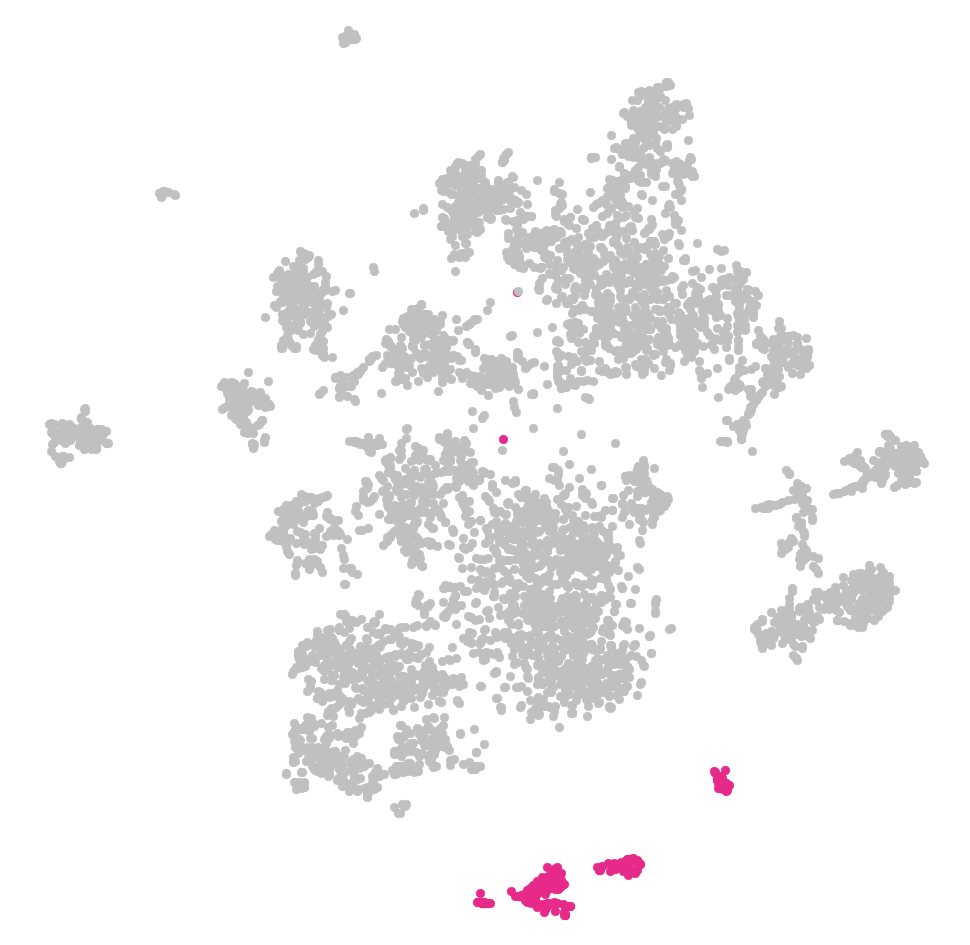

In [29]:
cells = cl_c_1st[cl_c_1st!='JUNK']
tsne = tsne_1st.loc[cells.index]
cmap = cmap_1st
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:
    
    if cells[ix] != 'IMM':
        ax1.scatter(tsne.loc[ix,'x'],
                    tsne.loc[ix,'y'], 
                    s = 75,
                    linewidth = 0.5,
                    c = 'silver',
                    edgecolor='silver', 
                    marker = markers[time[ix]])
        
    else:
        ax1.scatter(tsne.loc[ix,'x'],
                    tsne.loc[ix,'y'], 
                    s = 75,
                    linewidth = 0.5,
                    c = cmap_1st['IMM'],
                    edgecolor=cmap_1st['IMM'], 
                    marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_IMM_sel.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Vascular cells

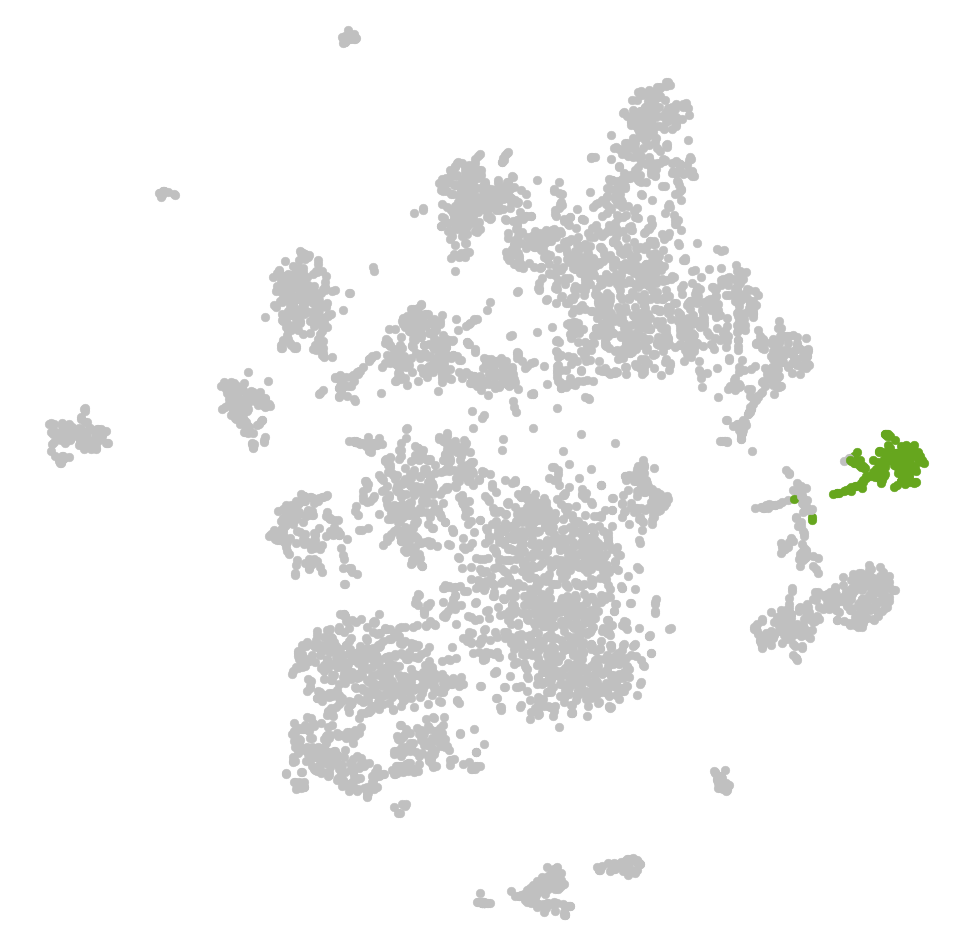

In [30]:
cells = cl_c_1st[cl_c_1st!='JUNK']
tsne = tsne_1st.loc[cells.index]
cmap = cmap_1st
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:
    
    if cells[ix] != 'VASC':
        ax1.scatter(tsne.loc[ix,'x'],
                    tsne.loc[ix,'y'], 
                    s = 75,
                    linewidth = 0.5,
                    c = 'silver',
                    edgecolor='silver', 
                    marker = markers[time[ix]])
        
    else:
        ax1.scatter(tsne.loc[ix,'x'],
                    tsne.loc[ix,'y'], 
                    s = 75,
                    linewidth = 0.5,
                    c = cmap_1st['VASC'],
                    edgecolor=cmap_1st['VASC'], 
                    marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_VASC_sel.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Neural crest cells

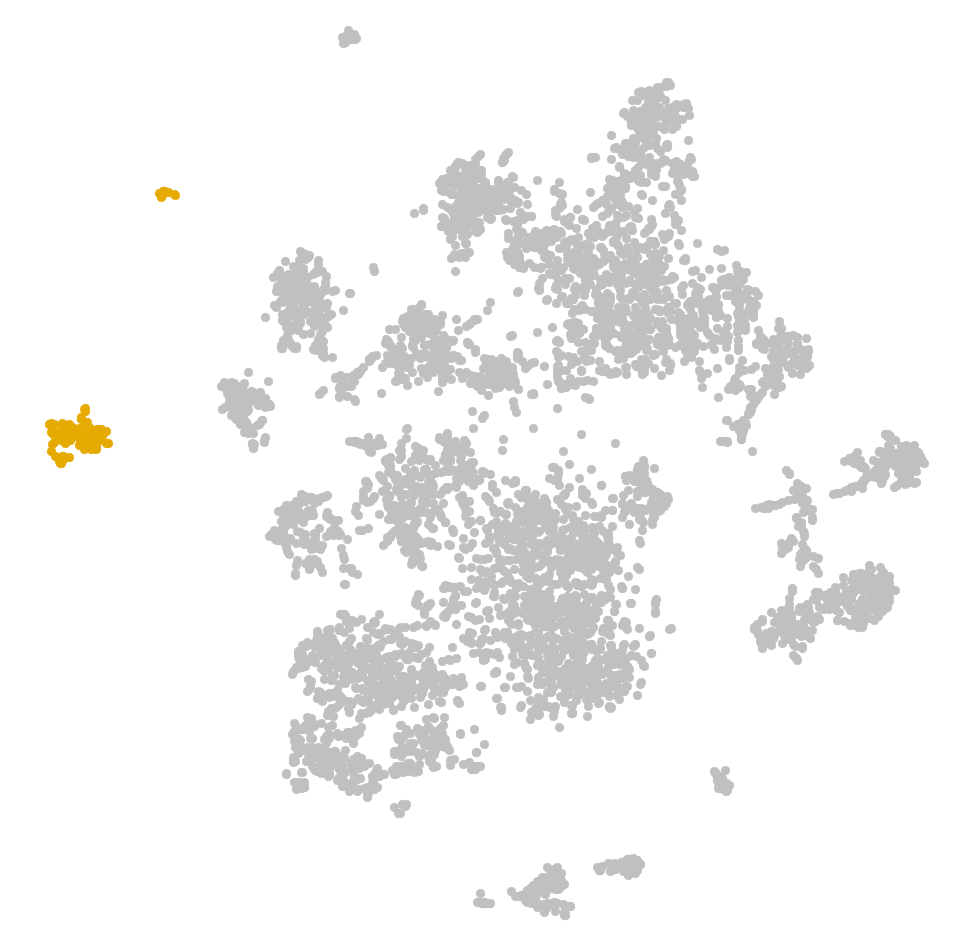

In [31]:
cells = cl_c_1st[cl_c_1st!='JUNK']
tsne = tsne_1st.loc[cells.index]
cmap = cmap_1st
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:
    
    if cells[ix] != 'MEL':
        ax1.scatter(tsne.loc[ix,'x'],
                    tsne.loc[ix,'y'], 
                    s = 75,
                    linewidth = 0.5,
                    c = 'silver',
                    edgecolor='silver', 
                    marker = markers[time[ix]])
        
    else:
        ax1.scatter(tsne.loc[ix,'x'],
                    tsne.loc[ix,'y'], 
                    s = 75,
                    linewidth = 0.5,
                    c = cmap_1st['MEL'],
                    edgecolor=cmap_1st['MEL'], 
                    marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_MEL_sel.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Misc cells

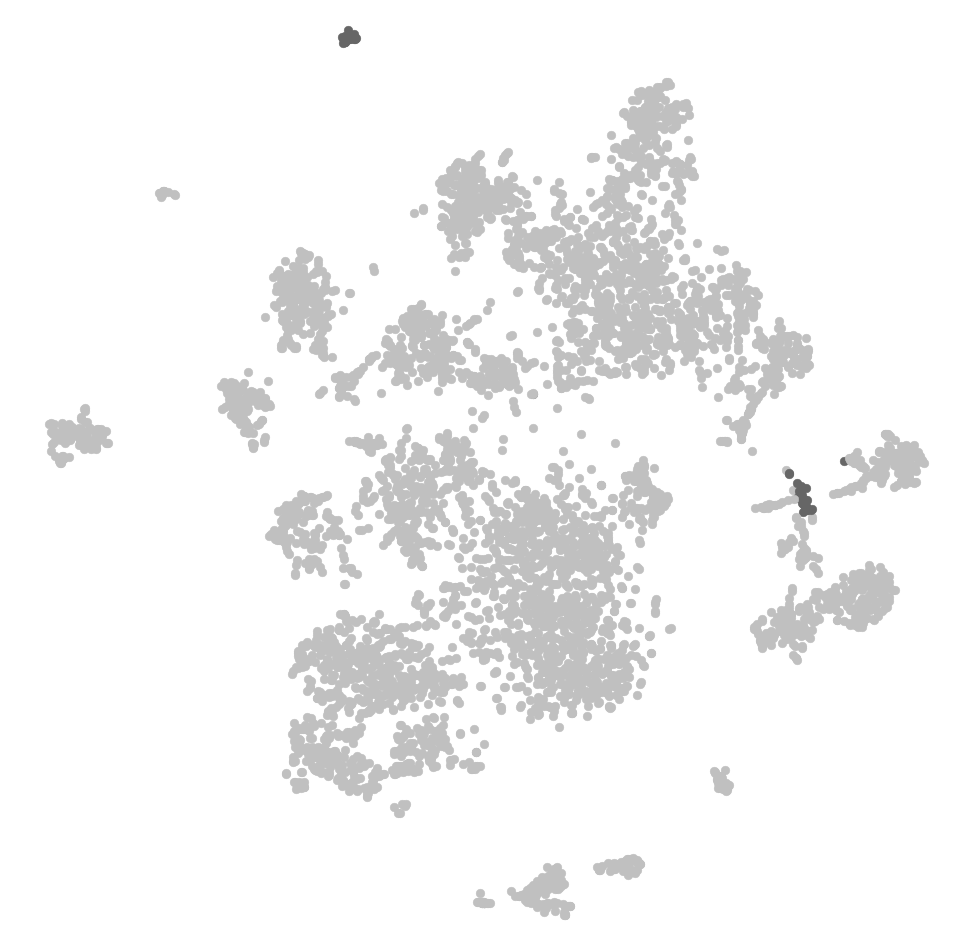

In [32]:
cells = cl_c_1st[cl_c_1st!='JUNK']
tsne = tsne_1st.loc[cells.index]
cmap = cmap_1st
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:
    
    if cells[ix] != 'MISC':
        ax1.scatter(tsne.loc[ix,'x'],
                    tsne.loc[ix,'y'], 
                    s = 75,
                    linewidth = 0.5,
                    c = 'silver',
                    edgecolor='silver', 
                    marker = markers[time[ix]])
        
    else:
        ax1.scatter(tsne.loc[ix,'x'],
                    tsne.loc[ix,'y'], 
                    s = 75,
                    linewidth = 0.5,
                    c = cmap_1st['MISC'],
                    edgecolor=cmap_1st['MISC'], 
                    marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_MISC_sel.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# tSNE - cell groups

## Immune cells

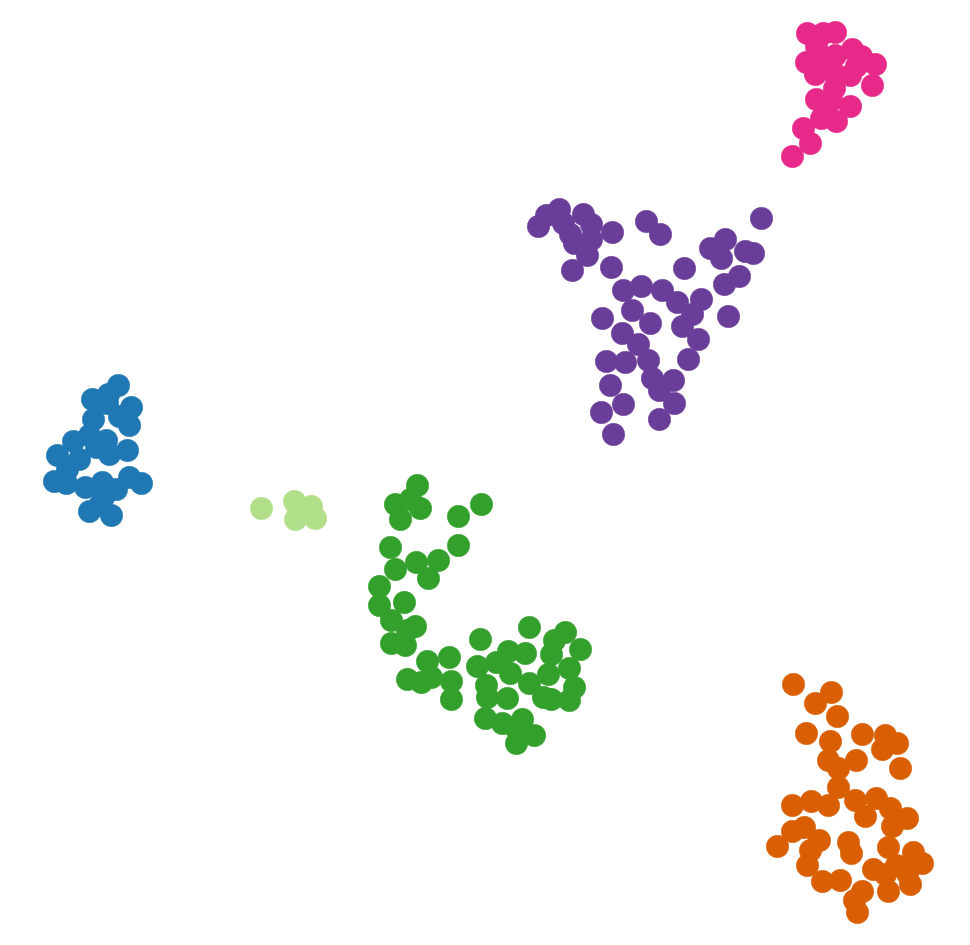

In [33]:
cells = cl_c_IMM
tsne = umap_IMM.loc[cells.index]
cmap = cmap_2nd
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 500,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_IMM.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Vascular cells

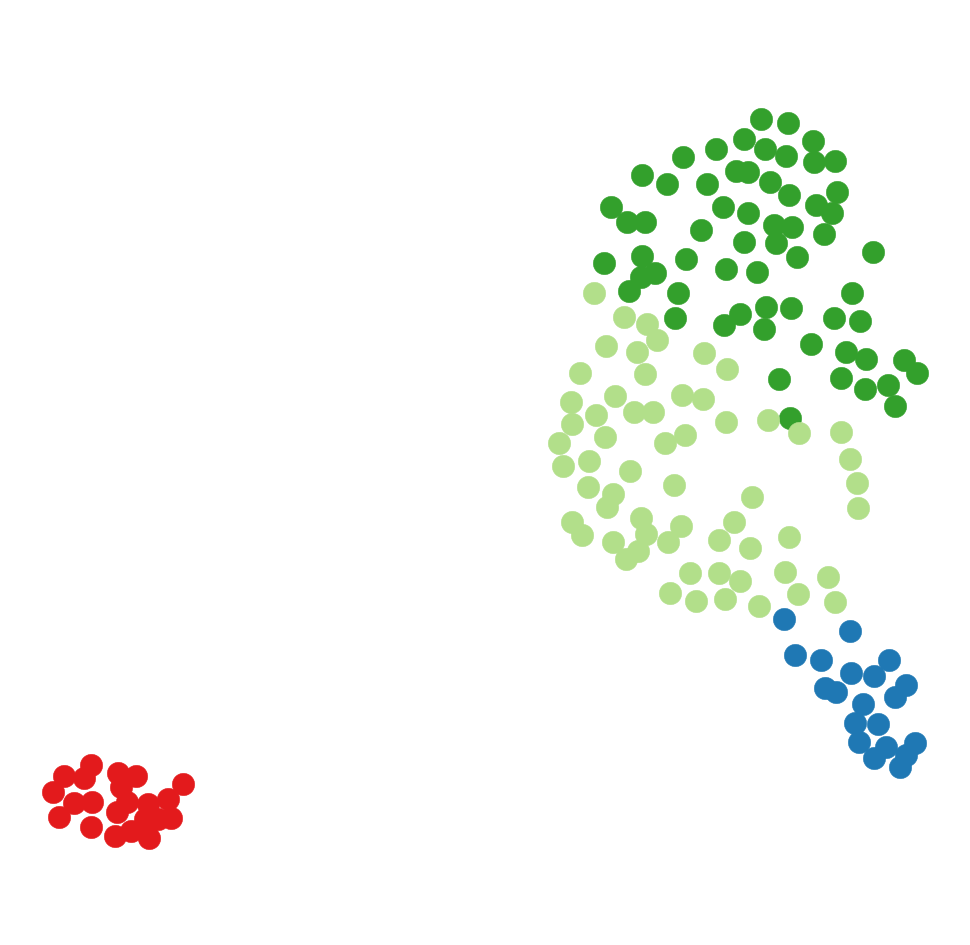

In [34]:
cells = cl_c_VASC
tsne = umap_VASC.loc[cells.index]
cmap = cmap_2nd
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 500,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_VASC.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Neural crest cells

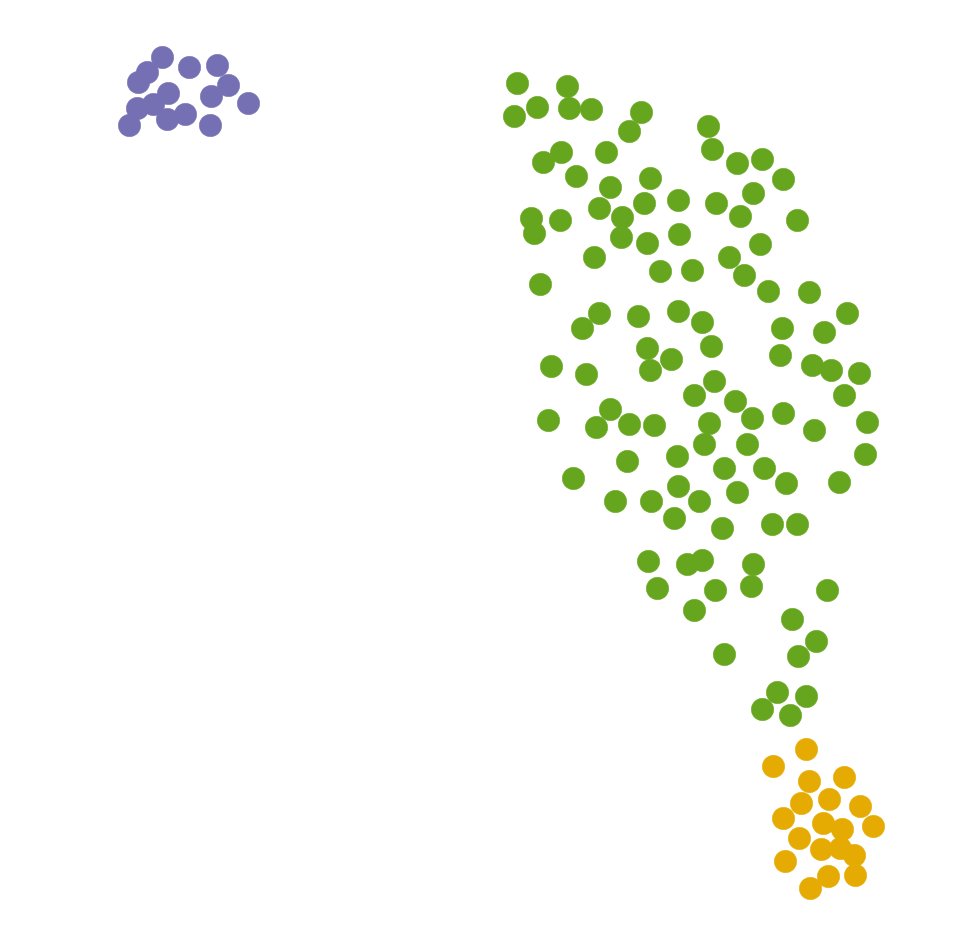

In [35]:
cells = cl_c_MEL
tsne = umap_MEL.loc[cells.index]
cmap = cmap_2nd
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 500,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_MEL.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Miscellaneous

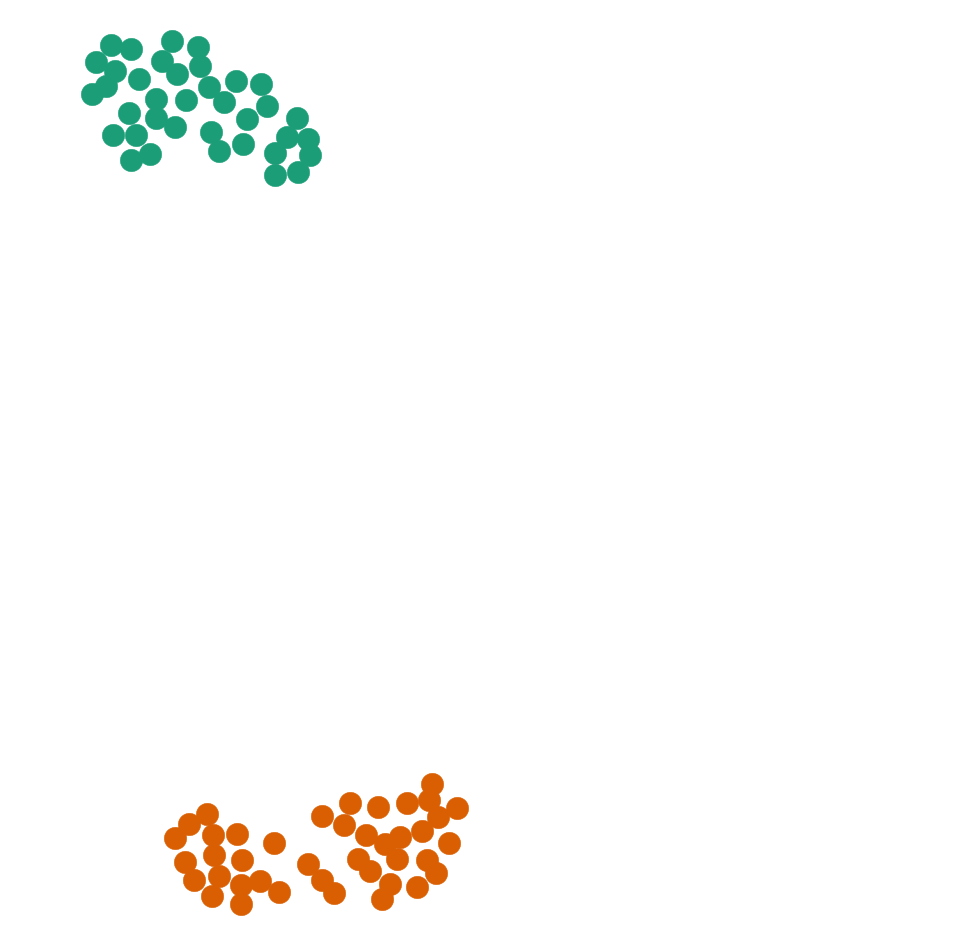

In [36]:
cells = cl_c_MISC
tsne = umap_MISC.loc[cells.index]
cmap = cmap_2nd
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 500,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_MISC.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# tSNE - time points

## Immune cells

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


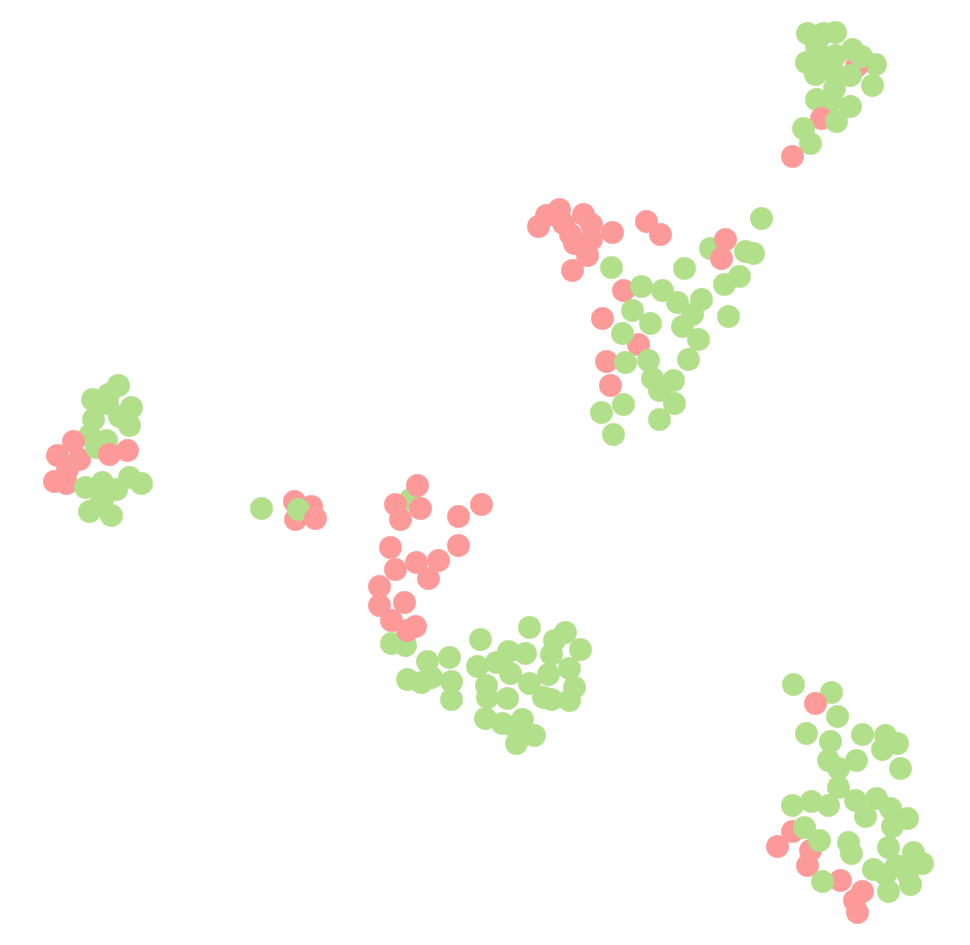

In [37]:
cells = cl_c_IMM
tsne = umap_IMM.ix[cells.index]
cmap = cmap_time
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in tsne.index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 500,
                linewidth = 0.5,
                c = cmap[time[ix]],
                edgecolor=cmap[time[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_IMM_time.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Vascular cells

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


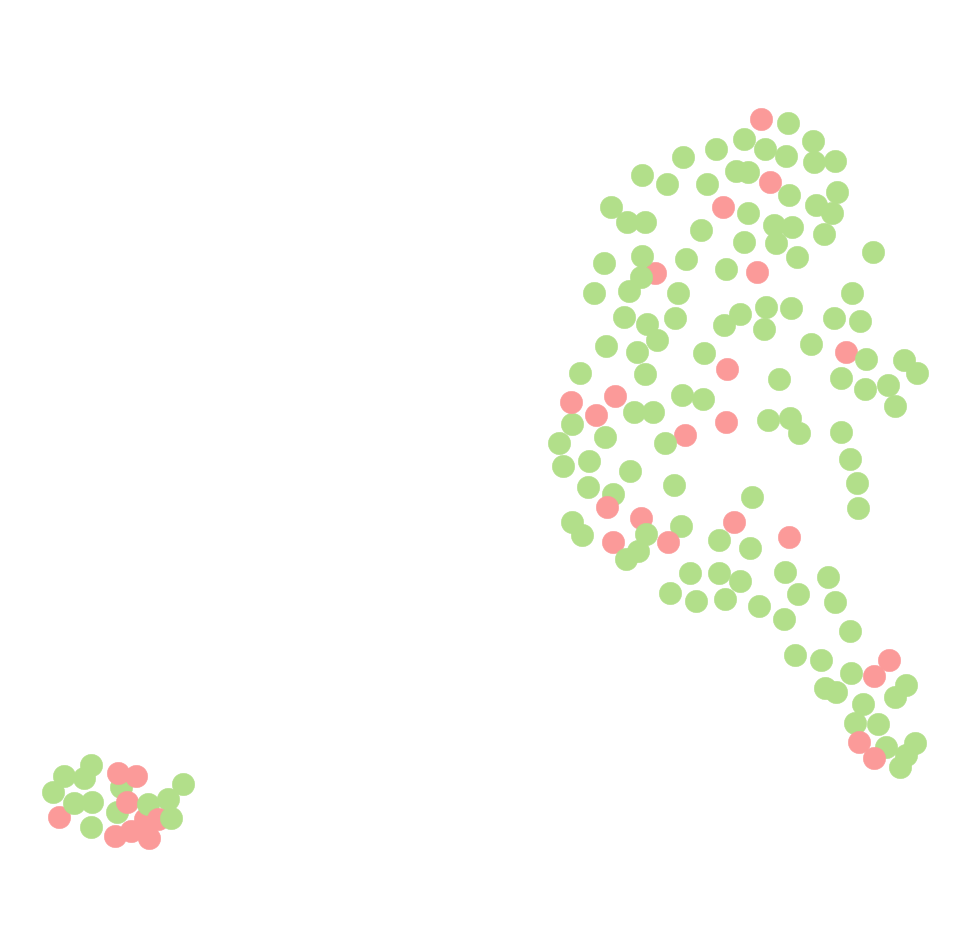

In [38]:
cells = cl_c_VASC
tsne = umap_VASC.ix[cells.index]
cmap = cmap_time
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in tsne.index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 500,
                linewidth = 0.5,
                c = cmap[time[ix]],
                edgecolor=cmap[time[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_VASC_time.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Neural crest cells

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


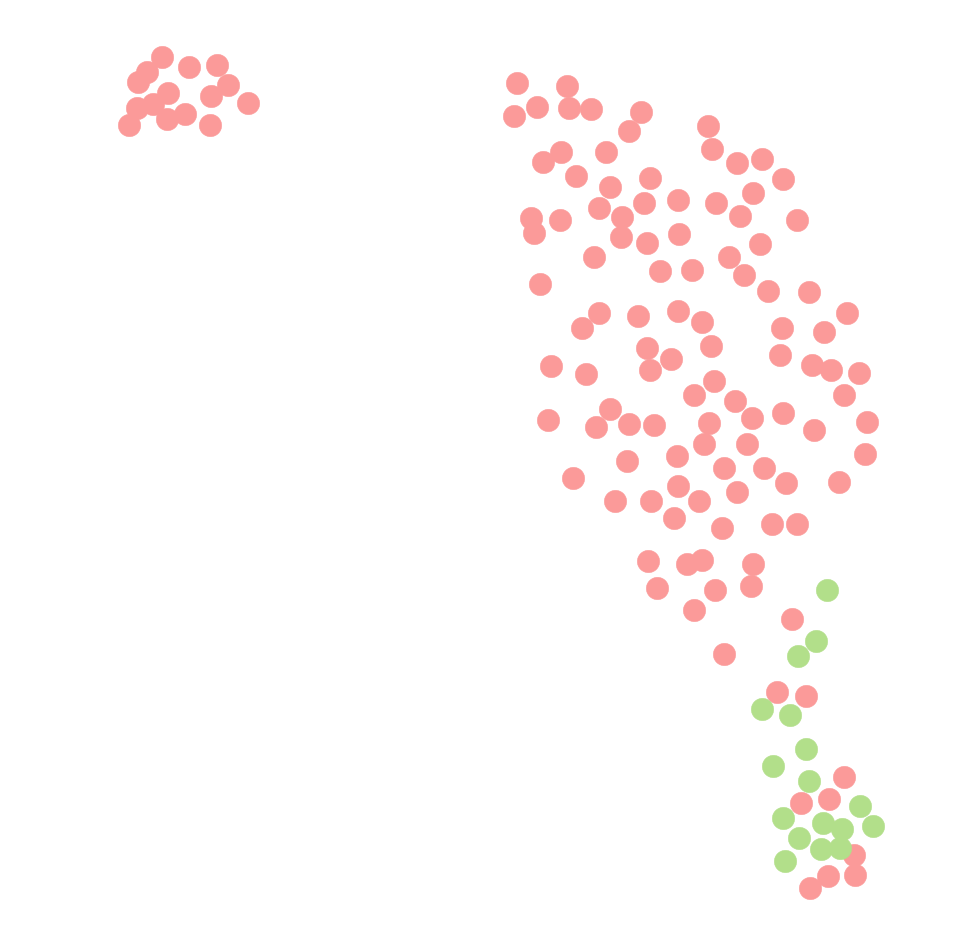

In [39]:
cells = cl_c_MEL
tsne = umap_MEL.ix[cells.index]
cmap = cmap_time
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in tsne.index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 500,
                linewidth = 0.5,
                c = cmap[time[ix]],
                edgecolor=cmap[time[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_MEL_time.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Miscellaneous

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


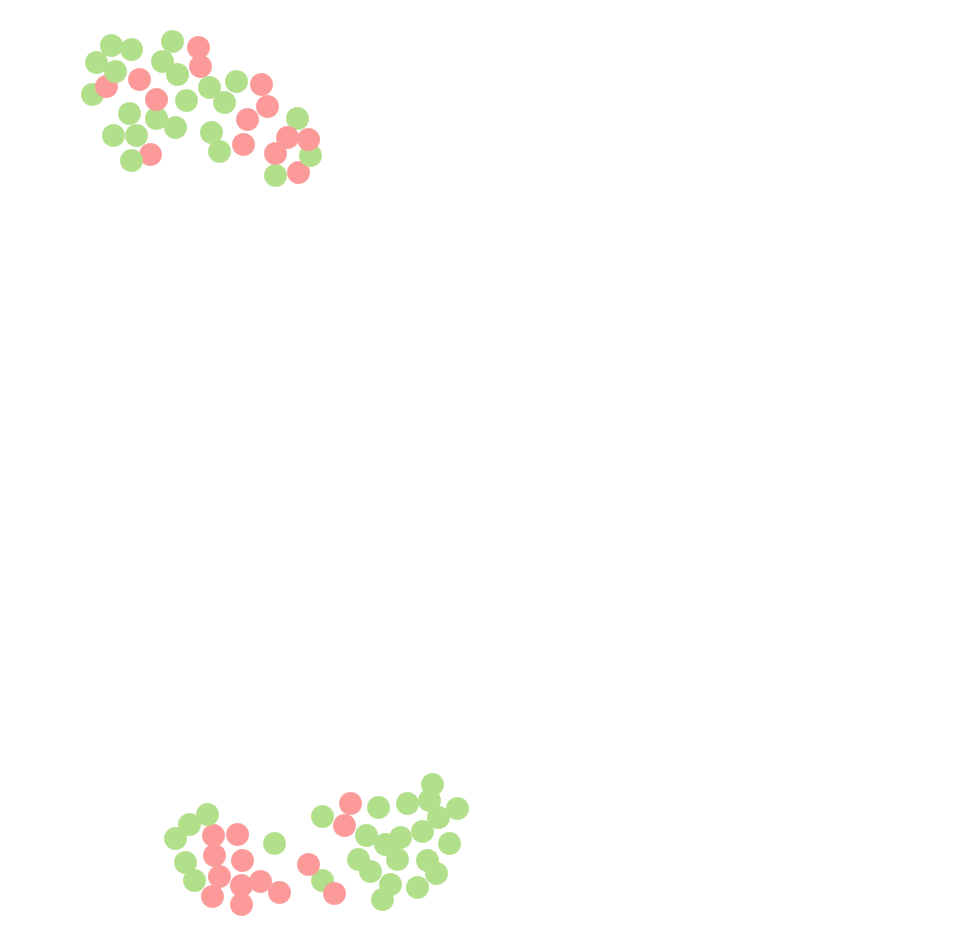

In [40]:
cells = cl_c_MISC
tsne = umap_MISC.ix[cells.index]
cmap = cmap_time
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in tsne.index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 500,
                linewidth = 0.5,
                c = cmap[time[ix]],
                edgecolor=cmap[time[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_MISC_time.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# tSNE - replicates

## Immune cells

In [29]:
cmap_replicate = {'9wk1':'#238b45',
                  '9wk2':'#74c476',
                  '9w unassigned':'#bae4b3',
                  '5wk1':'#cb181d',
                  '5wk2':'#fb6a4a',
                  '5wk3':'#fcae91',
                  '5w unassigned':'#fee5d9'}

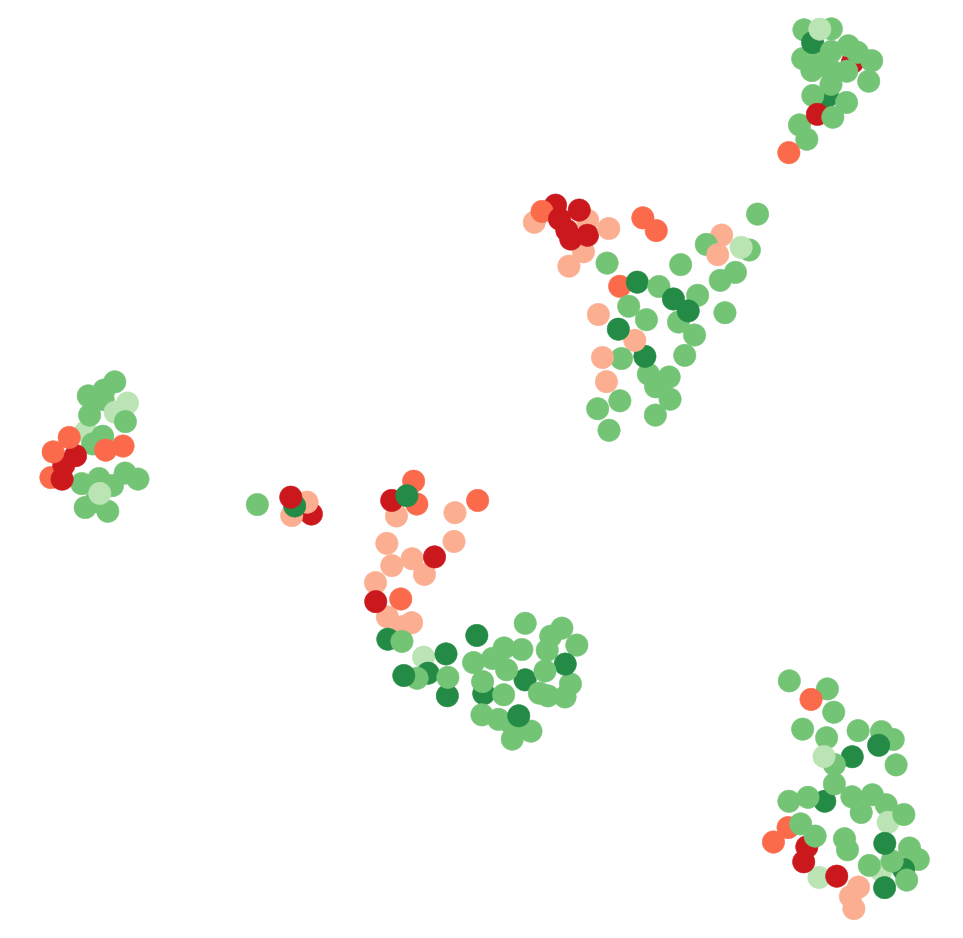

In [30]:
cells = cl_c_IMM
tsne = umap_IMM.loc[cells.index]
cmap = cmap_replicate
time = cells_replicate

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[time[i]] for i in index]

ax1.scatter(tsne.loc[index,'x'],
            tsne.loc[index,'y'], 
            s = 500,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_IMM_replicate.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

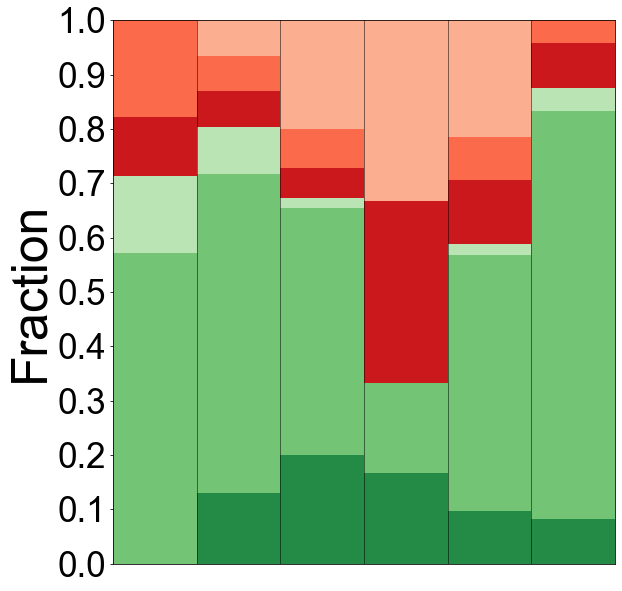

In [31]:
groups = cl_c_IMM
replicates = cells_replicate
cmap = cmap_replicate

#initialize figure

height = 10
width = len(return_unique(groups)) * 1.5

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#set axes

ax = plt.subplot(111)

ax.set_xlim(-0.5, len(return_unique(groups))-0.5)
ax.set_xticks([])

ax.set_ylim(0,1)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_yticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], family = 'Arial', fontsize = 35)
ax.set_ylabel('Fraction', fontsize = 50, family = 'Arial')

#get data

for pos, gr in enumerate(return_unique(groups)):
    c_tmp = groups[groups==gr].index
    l = len(c_tmp)
    rep_tmp = Counter(replicates[c_tmp])
    y = 0
    for r in ['9wk1','9wk2','9w unassigned','5wk1','5wk2','5wk3','5w unassigned']:
        y_new = y + rep_tmp[r]/l
        ax.bar(x = pos, bottom=y, height=y_new, width=1, color = cmap[r])
        y = y_new
    ax.axvline(pos+0.5, color = 'k', linewidth = 0.5)
    
figname = 'v1.5_Fig6_bar_IMM_replicate.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Vascular cells

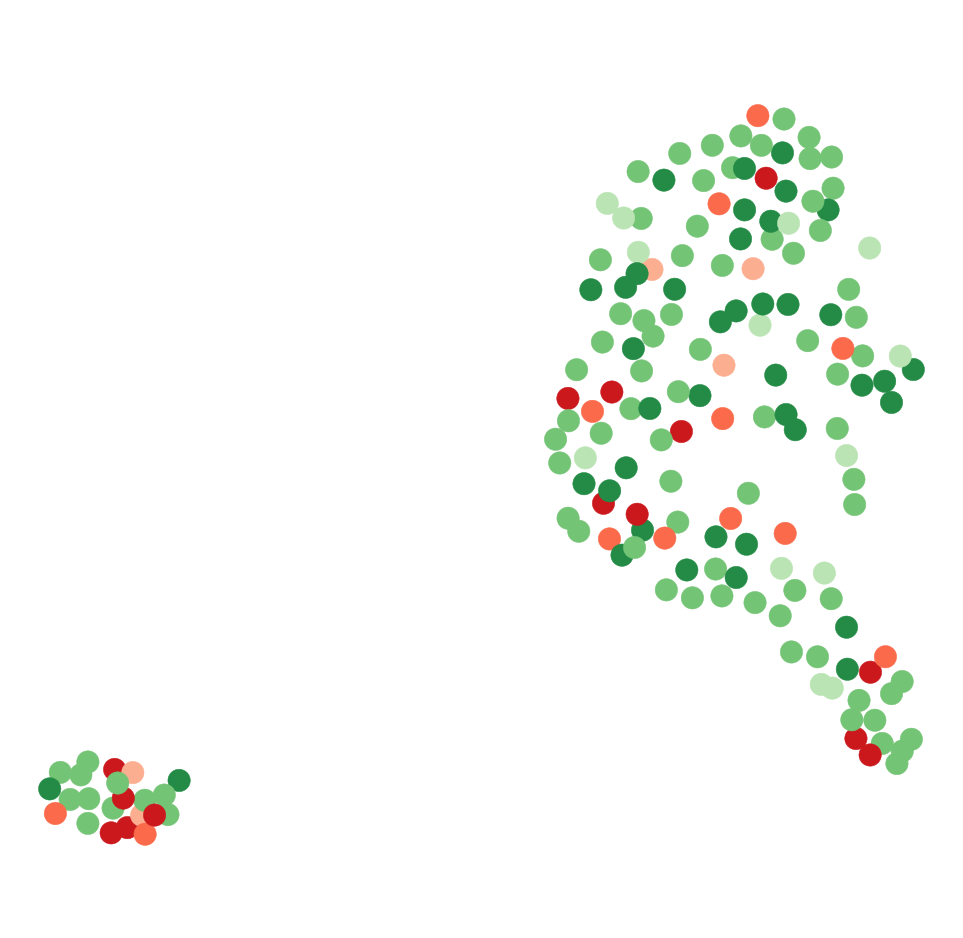

In [32]:
cells = cl_c_VASC
tsne = umap_VASC.loc[cells.index]
cmap = cmap_replicate
time = cells_replicate

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[time[i]] for i in index]

ax1.scatter(tsne.loc[index,'x'],
            tsne.loc[index,'y'], 
            s = 500,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_VASC_replicate.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

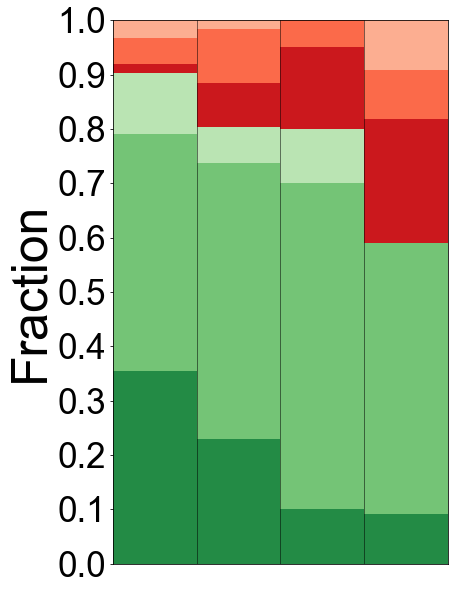

In [33]:
groups = cl_c_VASC
replicates = cells_replicate
cmap = cmap_replicate

#initialize figure

height = 10
width = len(return_unique(groups)) * 1.5

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#set axes

ax = plt.subplot(111)

ax.set_xlim(-0.5, len(return_unique(groups))-0.5)
ax.set_xticks([])

ax.set_ylim(0,1)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_yticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], family = 'Arial', fontsize = 35)
ax.set_ylabel('Fraction', fontsize = 50, family = 'Arial')

#get data

for pos, gr in enumerate(return_unique(groups)):
    c_tmp = groups[groups==gr].index
    l = len(c_tmp)
    rep_tmp = Counter(replicates[c_tmp])
    y = 0
    for r in ['9wk1','9wk2','9w unassigned','5wk1','5wk2','5wk3','5w unassigned']:
        y_new = y + rep_tmp[r]/l
        ax.bar(x = pos, bottom=y, height=y_new, width=1, color = cmap[r])
        y = y_new
    ax.axvline(pos+0.5, color = 'k', linewidth = 0.5)
    
figname = 'v1.5_Fig6_bar_VASC_replicate.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Neural crest derived

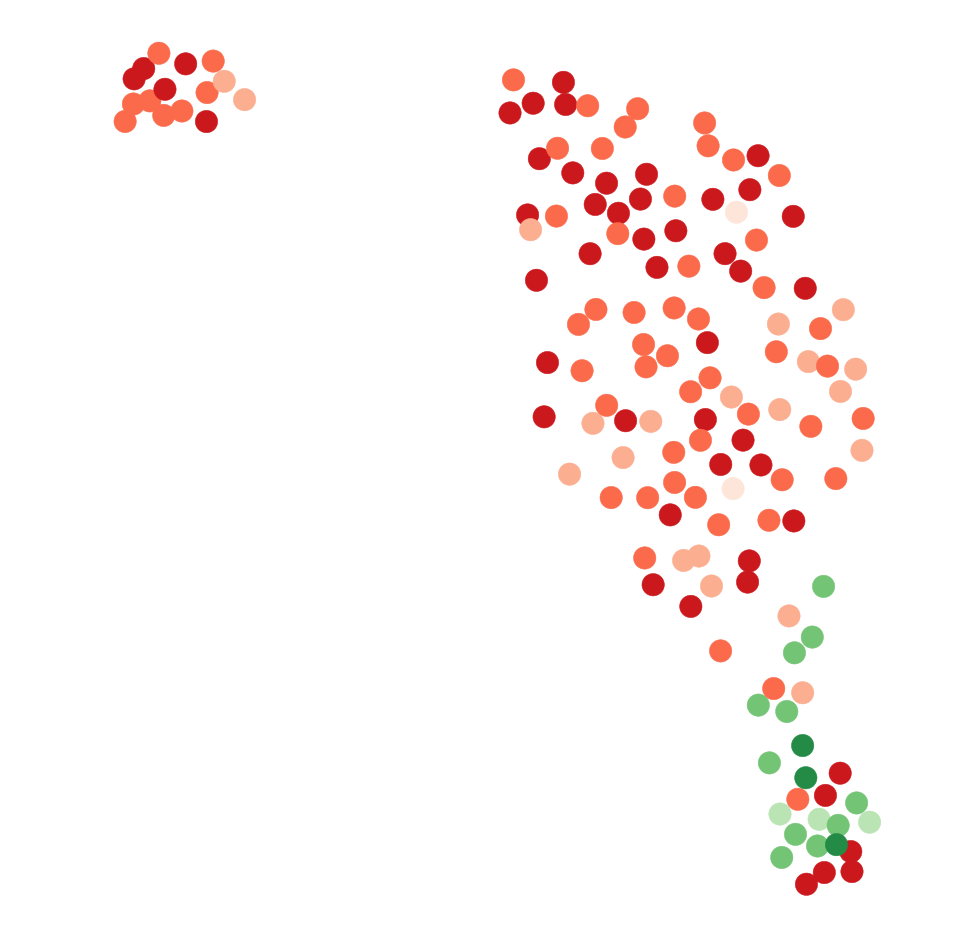

In [34]:
cells = cl_c_MEL
tsne = umap_MEL.loc[cells.index]
cmap = cmap_replicate
time = cells_replicate

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[time[i]] for i in index]

ax1.scatter(tsne.loc[index,'x'],
            tsne.loc[index,'y'], 
            s = 500,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_MEL_replicate.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

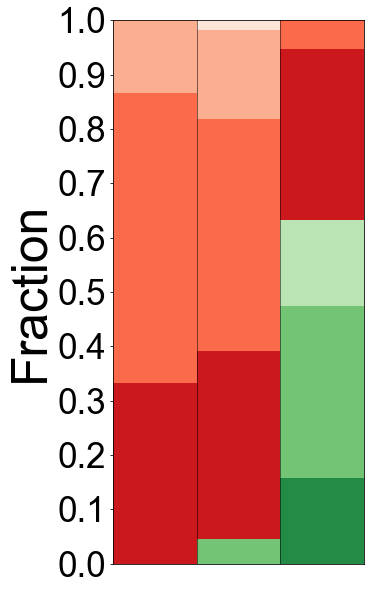

In [35]:
groups = cl_c_MEL
replicates = cells_replicate
cmap = cmap_replicate

#initialize figure

height = 10
width = len(return_unique(groups)) * 1.5

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#set axes

ax = plt.subplot(111)

ax.set_xlim(-0.5, len(return_unique(groups))-0.5)
ax.set_xticks([])

ax.set_ylim(0,1)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_yticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], family = 'Arial', fontsize = 35)
ax.set_ylabel('Fraction', fontsize = 50, family = 'Arial')

#get data

for pos, gr in enumerate(return_unique(groups)):
    c_tmp = groups[groups==gr].index
    l = len(c_tmp)
    rep_tmp = Counter(replicates[c_tmp])
    y = 0
    for r in ['9wk1','9wk2','9w unassigned','5wk1','5wk2','5wk3','5w unassigned']:
        y_new = y + rep_tmp[r]/l
        ax.bar(x = pos, bottom=y, height=y_new, width=1, color = cmap[r])
        y = y_new
    ax.axvline(pos+0.5, color = 'k', linewidth = 0.5)
    
figname = 'v1.5_Fig6_bar_MEL_replicate.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Miscellaneous

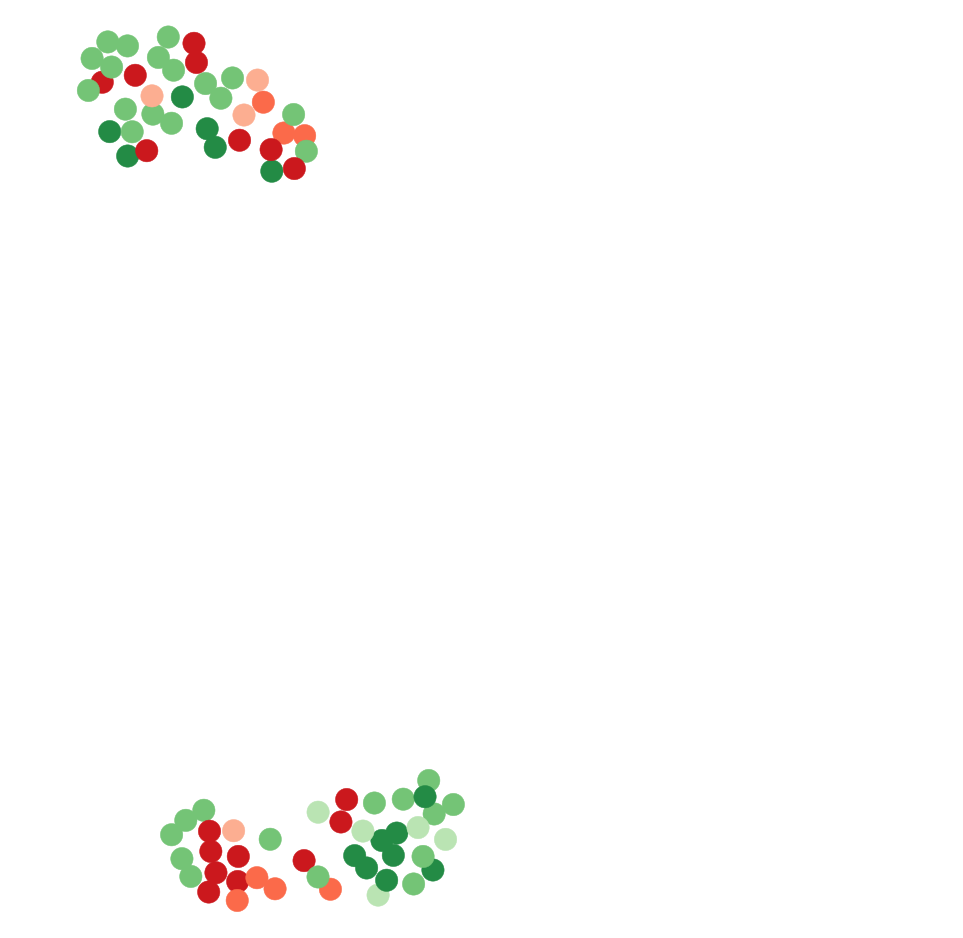

In [36]:
cells = cl_c_MISC
tsne = umap_MISC.loc[cells.index]
cmap = cmap_replicate
time = cells_replicate

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[time[i]] for i in index]

ax1.scatter(tsne.loc[index,'x'],
            tsne.loc[index,'y'], 
            s = 500,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_MISC_replicate.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

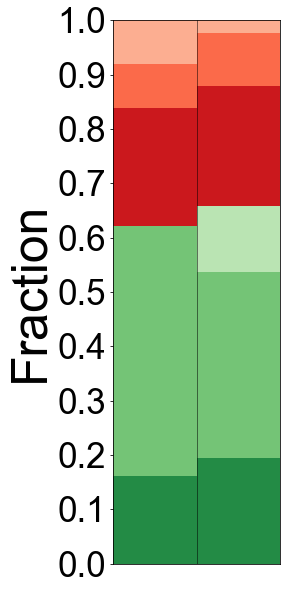

In [37]:
groups = cl_c_MISC
replicates = cells_replicate
cmap = cmap_replicate

#initialize figure

height = 10
width = len(return_unique(groups)) * 1.5

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#set axes

ax = plt.subplot(111)

ax.set_xlim(-0.5, len(return_unique(groups))-0.5)
ax.set_xticks([])

ax.set_ylim(0,1)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_yticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], family = 'Arial', fontsize = 35)
ax.set_ylabel('Fraction', fontsize = 50, family = 'Arial')

#get data

for pos, gr in enumerate(return_unique(groups)):
    c_tmp = groups[groups==gr].index
    l = len(c_tmp)
    rep_tmp = Counter(replicates[c_tmp])
    y = 0
    for r in ['9wk1','9wk2','9w unassigned','5wk1','5wk2','5wk3','5w unassigned']:
        y_new = y + rep_tmp[r]/l
        ax.bar(x = pos, bottom=y, height=y_new, width=1, color = cmap[r])
        y = y_new
    ax.axvline(pos+0.5, color = 'k', linewidth = 0.5)
    
figname = 'v1.5_Fig6_bar_MISC_replicate.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Barplots

## Immune cells

In [32]:
def get_cluster_ticks(cl):

    ticks = []
    cnt = 0
    
    for i in return_unique(cl):
        l = Counter(cl)[i]
        ticks += [cnt + l / 2]
        cnt += l
        
    return ticks

In [31]:
genes = ['Cd3e','Thy1',
         'C1qa','Cd209f',
         'Ccl6','Lyz1',
         'Ly6c2','Emilin2',
         'Cd209a','Cd74',
         'Cd207','Mfge8']

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


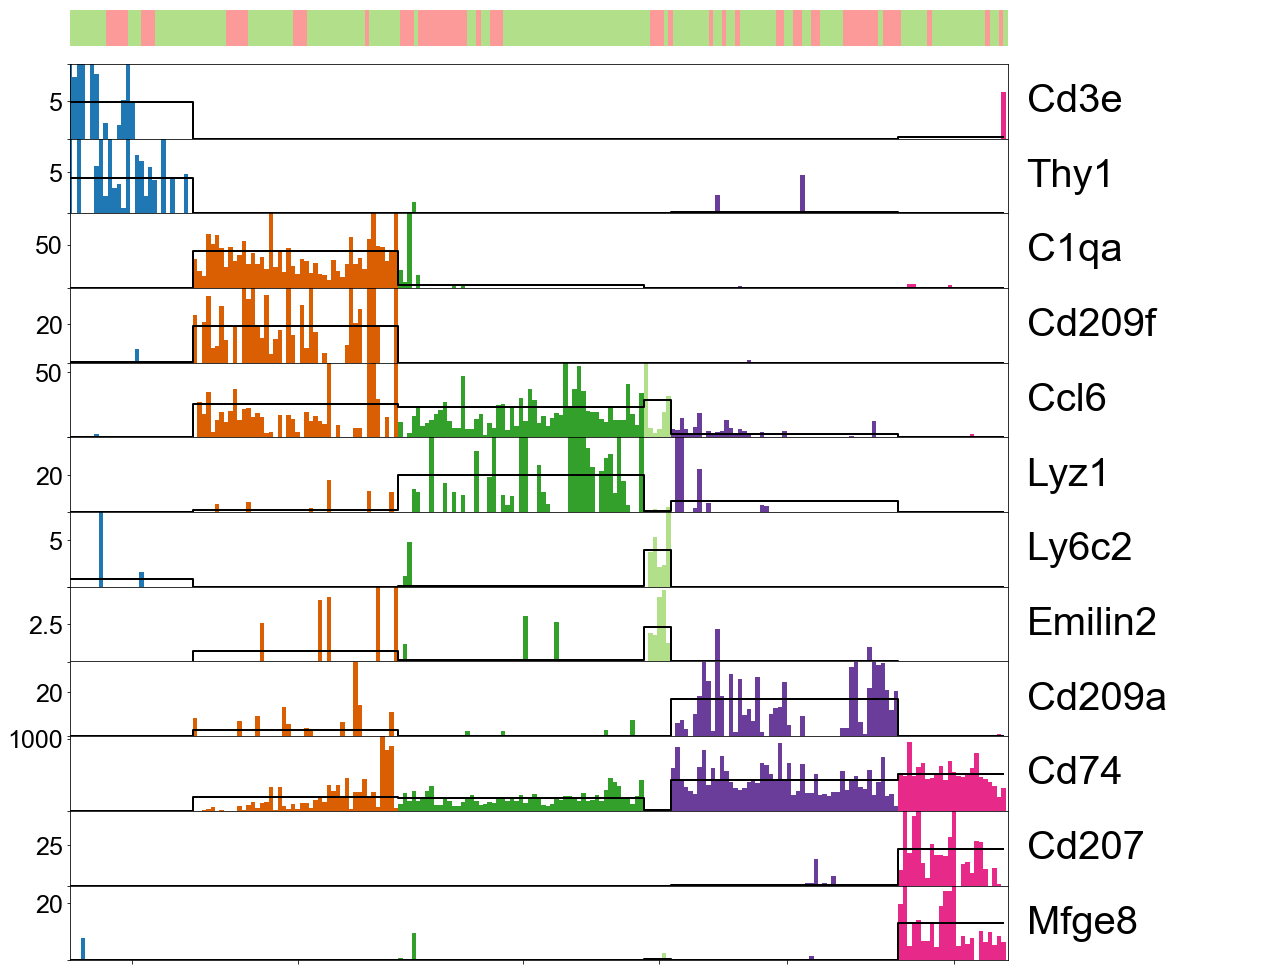

In [32]:
cell_groups = cl_c_IMM
dataset = seqN[cl_c_IMM.index]
#genes = ['Trdv4']
cmap = cmap_2nd

#create figure

bar_size = 0.5
bar_pad = 0.25
width = 17.5
height = len(genes) * 1.1

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#create GS for gene barplots

gs1 = plt.GridSpec(len(genes), 2, hspace = 0.00, wspace = 0.0, top = 1 - ((bar_pad + bar_size) / height), right = 1, 
                   left = (bar_pad + bar_size) / width, bottom = 0, width_ratios = [14,4])

#create GS for sample group bar

gs0 = plt.GridSpec(1,2, left = (bar_pad + bar_size) / width, right = 1, top = 1,
                       bottom = 1 - ((bar_size) / height), hspace = 0.0, wspace = 0.0, width_ratios = [14,4])

#colorlist bar

clistBAR = [cmap[val] for val in cell_groups]

#draw genes

for g in genes:
    
        #create group_specific mean expressions
    
        mean_tmp = pd.Series(index = set(cell_groups))
        
        for gr in set(cell_groups):
            
            ix_tmp = cell_groups[cell_groups == gr].index
            mean_tmp[gr] = dataset.ix[g, ix_tmp].mean()
            
        #create white space for gene names
        
        ax0 = plt.subplot(gs1[genes.index(g),1])
        clean_axis(ax0)
 
        #create axis
            
        ax0 = plt.subplot(gs1[genes.index(g),0])
        
        ax0.axvspan(0, len(dataset.columns), color = '#FFFFFF', zorder = 0)
        
        #define xaxis
        
        ax0.set_xlim(left = 0, right = (len(dataset.columns)))
        ax0.xaxis.set_ticks(get_cluster_ticks(cell_groups))
        ax0.xaxis.set_ticklabels([])
        
        #define yaxis
        
        ax0.set_ylim(bottom = 0, top = np.ceil(np.max(mean_tmp) * 2))
        ax0.set_ylabel(g, family = 'Arial', fontsize = 40, rotation = 'horizontal', va = 'center', ha = 'left')
        ax0.yaxis.set_label_coords(1.02, 0.5)
        
        ax0.locator_params(axis='y', nbins=2)
        
        for tick_pos, tick in enumerate(ax0.yaxis.get_major_ticks()):
            if tick_pos % 2 == 1:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)
            else:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_visible(False)
                
        #draw expression data
        
        ax0.bar(np.arange(0, len(dataset.columns),1), dataset.ix[g], color = clistBAR, linewidth = 0, width = 1.0)
        
        #draw means
        
        ax0.step(range(len(cell_groups)), [mean_tmp[val] for val in cell_groups], where = 'mid', color = 'black', linewidth = 2)

ax1 = plt.subplot(gs0[0,0])

ax1.set_xlim(0, len(cell_groups))

for pos, c in enumerate(cell_groups.index):
    
    ax1.axvspan(xmin = pos, xmax = pos + 1, color = cmap_time[cells_stage[c]])

remove_ticks(ax1, linewidth = 1)
clean_axis(ax1)

figname = 'v1.5_Fig6_bar_IMM.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Vascular cells

In [33]:
#cl_c_VASC = AP_groups_reorder_v2(cl_c_VASC, ['VASC - 3', 'VASC - 1', 'VASC - 0', 'VASC - 2'])

In [62]:
genes = ['Pecam1','Aqp1','Fabp4','Rgcc',
         'Sparcl1','Acta2','Myl9','Tpm2',
         'Fxyd6','Fgl2','Lyve1','Prox1']

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


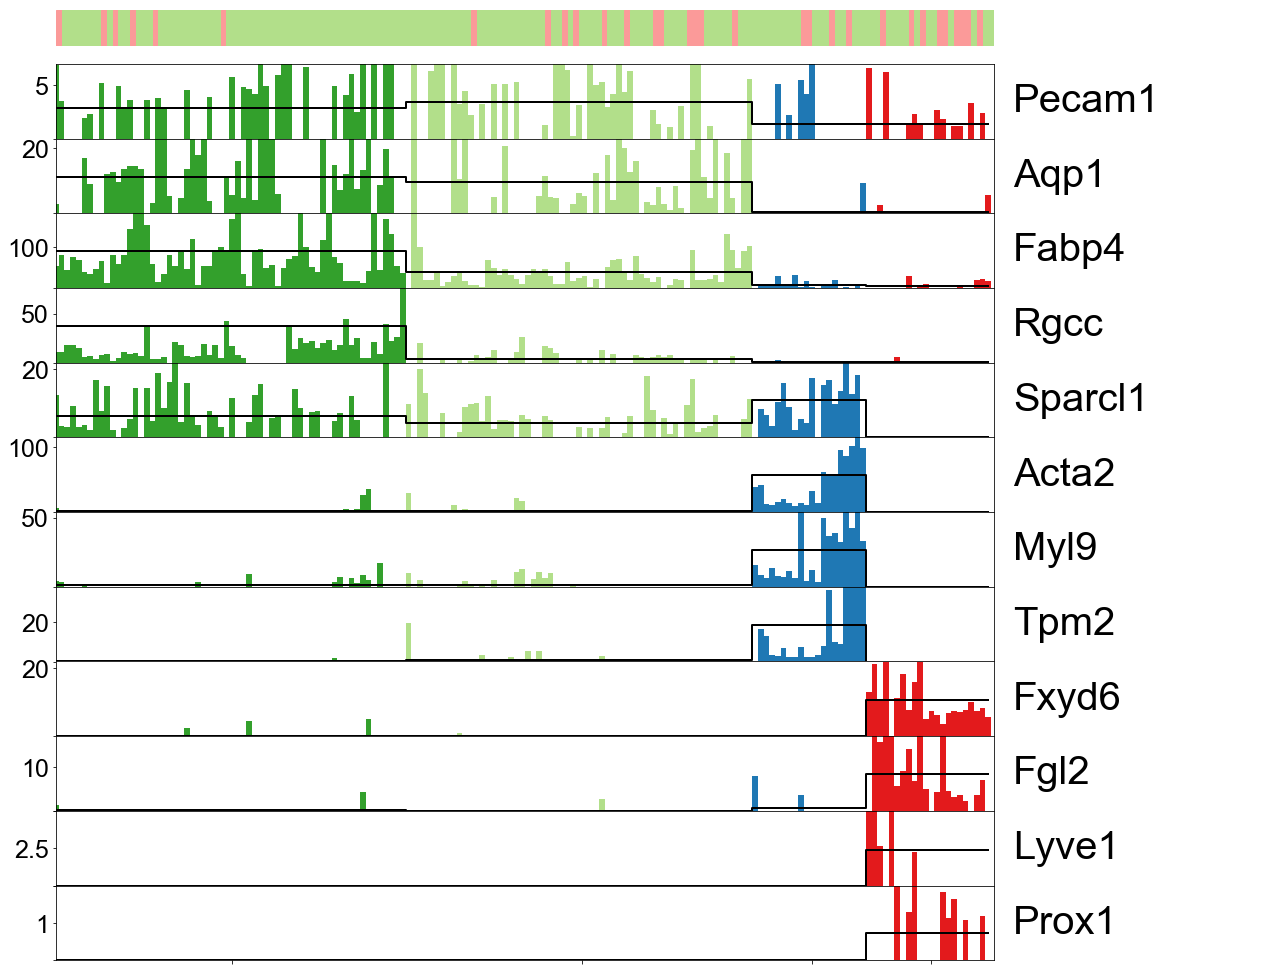

In [63]:
cell_groups = cl_c_VASC
dataset = seqN[cl_c_VASC.index]
#genes = ['Prox1']
cmap = cmap_2nd

#create figure

bar_size = 0.5
bar_pad = 0.25
width = 17.5
height = len(genes) * 1.1

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#create GS for gene barplots

gs1 = plt.GridSpec(len(genes), 2, hspace = 0.00, wspace = 0.0, top = 1 - ((bar_pad + bar_size) / height), right = 1, 
                   left = (bar_pad + bar_size) / width, bottom = 0, width_ratios = [14,4])

#create GS for sample group bar

gs0 = plt.GridSpec(1,2, left = (bar_pad + bar_size) / width, right = 1, top = 1,
                       bottom = 1 - ((bar_size) / height), hspace = 0.0, wspace = 0.0, width_ratios = [14,4])

#colorlist bar

clistBAR = [cmap[val] for val in cell_groups]

#draw genes

for g in genes:
    
        #create group_specific mean expressions
    
        mean_tmp = pd.Series(index = set(cell_groups))
        
        for gr in set(cell_groups):
            
            ix_tmp = cell_groups[cell_groups == gr].index
            mean_tmp[gr] = dataset.ix[g, ix_tmp].mean()
            
        #create white space for gene names
        
        ax0 = plt.subplot(gs1[genes.index(g),1])
        clean_axis(ax0)
 
        #create axis
            
        ax0 = plt.subplot(gs1[genes.index(g),0])
        
        ax0.axvspan(0, len(dataset.columns), color = '#FFFFFF', zorder = 0)
        
        #define xaxis
        
        ax0.set_xlim(left = 0, right = (len(dataset.columns)))
        ax0.xaxis.set_ticks(get_cluster_ticks(cell_groups))
        ax0.xaxis.set_ticklabels([])
        
        #define yaxis
        
        ax0.set_ylim(bottom = 0, top = np.ceil(np.max(mean_tmp) * 2))
        ax0.set_ylabel(g, family = 'Arial', fontsize = 40, rotation = 'horizontal', va = 'center', ha = 'left')
        ax0.yaxis.set_label_coords(1.02, 0.5)
        
        ax0.locator_params(axis='y', nbins=2)
        
        for tick_pos, tick in enumerate(ax0.yaxis.get_major_ticks()):
            if tick_pos % 2 == 1:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)
            else:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_visible(False)
                
        #draw expression data
        
        ax0.bar(np.arange(0, len(dataset.columns),1), dataset.ix[g], color = clistBAR, linewidth = 0, width = 1.0)
        
        #draw means
        
        ax0.step(range(len(cell_groups)), [mean_tmp[val] for val in cell_groups], where = 'mid', color = 'black', linewidth = 2)

ax1 = plt.subplot(gs0[0,0])

ax1.set_xlim(0, len(cell_groups))

for pos, c in enumerate(cell_groups.index):
    
    ax1.axvspan(xmin = pos, xmax = pos + 1, color = cmap_time[cells_stage[c]])

remove_ticks(ax1, linewidth = 1)
clean_axis(ax1)

figname = 'v1.5_Fig6_bar_VASC.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Melanocytes

In [36]:
genes = ['Pmel','Tyr','Dct',
         'Mlana','Npy','Pax3',
         'Atp6v1g1','Rps3','Tpt1',
         'Cnp','Mbp','Mpz']

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


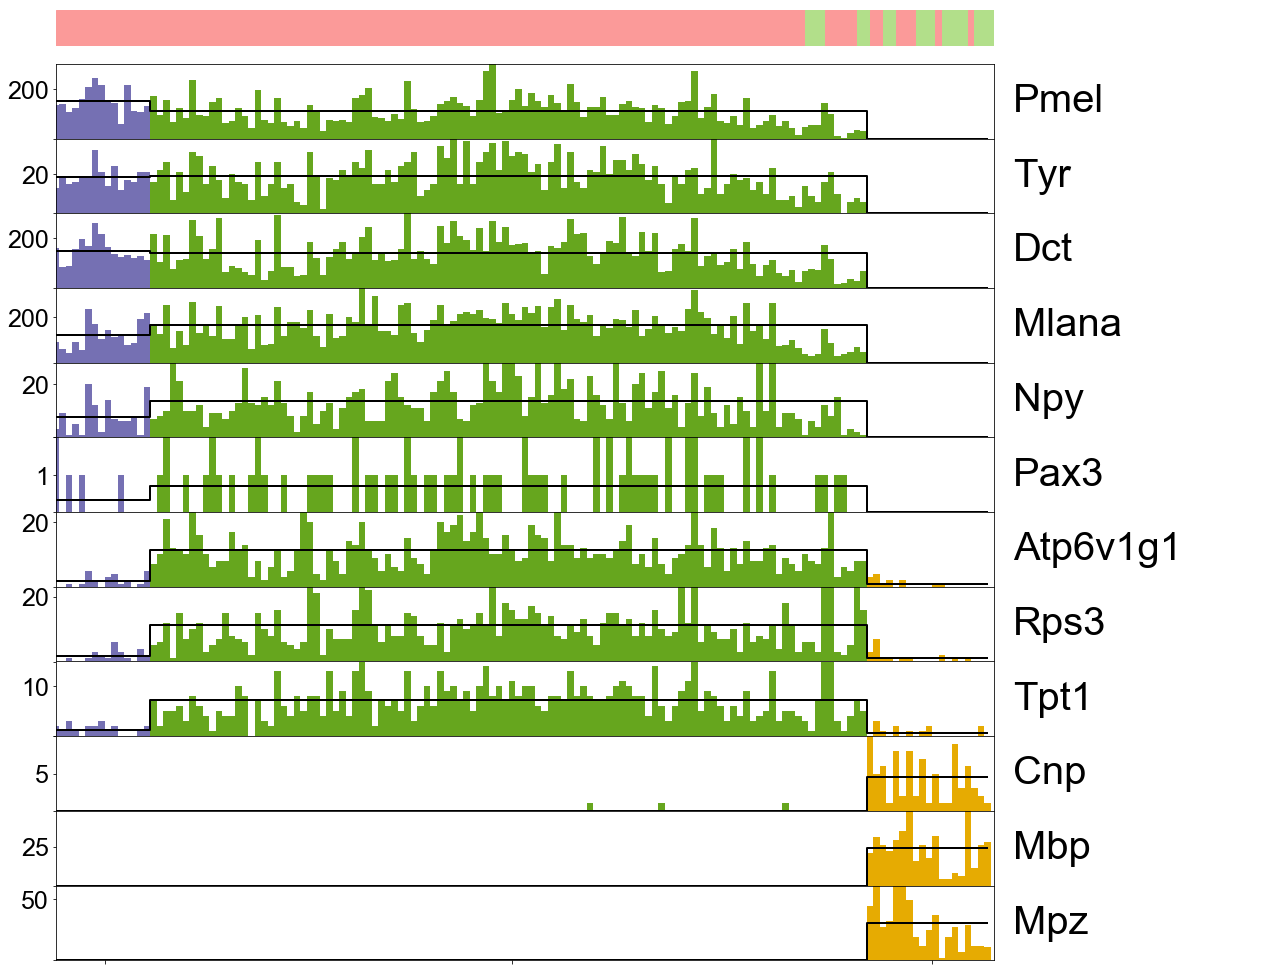

In [37]:
cell_groups = cl_c_MEL
dataset = seq[cl_c_MEL.index]
#genes = ['Atp6v1g1','Rps3','Tpt1']
cmap = cmap_2nd

#create figure

bar_size = 0.5
bar_pad = 0.25
width = 17.5
height = len(genes) * 1.1

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#create GS for gene barplots

gs1 = plt.GridSpec(len(genes), 2, hspace = 0.00, wspace = 0.0, top = 1 - ((bar_pad + bar_size) / height), right = 1, 
                   left = (bar_pad + bar_size) / width, bottom = 0, width_ratios = [14,4])

#create GS for sample group bar

gs0 = plt.GridSpec(1,2, left = (bar_pad + bar_size) / width, right = 1, top = 1,
                       bottom = 1 - ((bar_size) / height), hspace = 0.0, wspace = 0.0, width_ratios = [14,4])

#colorlist bar

clistBAR = [cmap[val] for val in cell_groups]

#draw genes

for g in genes:
    
        #create group_specific mean expressions
    
        mean_tmp = pd.Series(index = set(cell_groups))
        
        for gr in set(cell_groups):
            
            ix_tmp = cell_groups[cell_groups == gr].index
            mean_tmp[gr] = dataset.ix[g, ix_tmp].mean()
            
        #create white space for gene names
        
        ax0 = plt.subplot(gs1[genes.index(g),1])
        clean_axis(ax0)
 
        #create axis
            
        ax0 = plt.subplot(gs1[genes.index(g),0])
        
        ax0.axvspan(0, len(dataset.columns), color = '#FFFFFF', zorder = 0)
        
        #define xaxis
        
        ax0.set_xlim(left = 0, right = (len(dataset.columns)))
        ax0.xaxis.set_ticks(get_cluster_ticks(cell_groups))
        ax0.xaxis.set_ticklabels([])
        
        #define yaxis
        
        ax0.set_ylim(bottom = 0, top = np.ceil(np.max(mean_tmp) * 2))
        ax0.set_ylabel(g, family = 'Arial', fontsize = 40, rotation = 'horizontal', va = 'center', ha = 'left')
        ax0.yaxis.set_label_coords(1.02, 0.5)
        
        ax0.locator_params(axis='y', nbins=2)
        
        for tick_pos, tick in enumerate(ax0.yaxis.get_major_ticks()):
            if tick_pos % 2 == 1:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)
            else:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_visible(False)
                
        #draw expression data
        
        ax0.bar(np.arange(0, len(dataset.columns),1), dataset.ix[g], color = clistBAR, linewidth = 0, width = 1.0)
        
        #draw means
        
        ax0.step(range(len(cell_groups)), [mean_tmp[val] for val in cell_groups], where = 'mid', color = 'black', linewidth = 2)

ax1 = plt.subplot(gs0[0,0])

ax1.set_xlim(0, len(cell_groups))

for pos, c in enumerate(cell_groups.index):
    
    ax1.axvspan(xmin = pos, xmax = pos + 1, color = cmap_time[cells_stage[c]])

remove_ticks(ax1, linewidth = 1)
clean_axis(ax1)

figname = 'v1.5_Fig6_bar_MEL.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

### Miscellaneous

In [38]:
genes = ['Alas2','Hba-a1','Hba-a2','Hbb-bt','Des','Acta1','Cxcl1','Meg3']

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


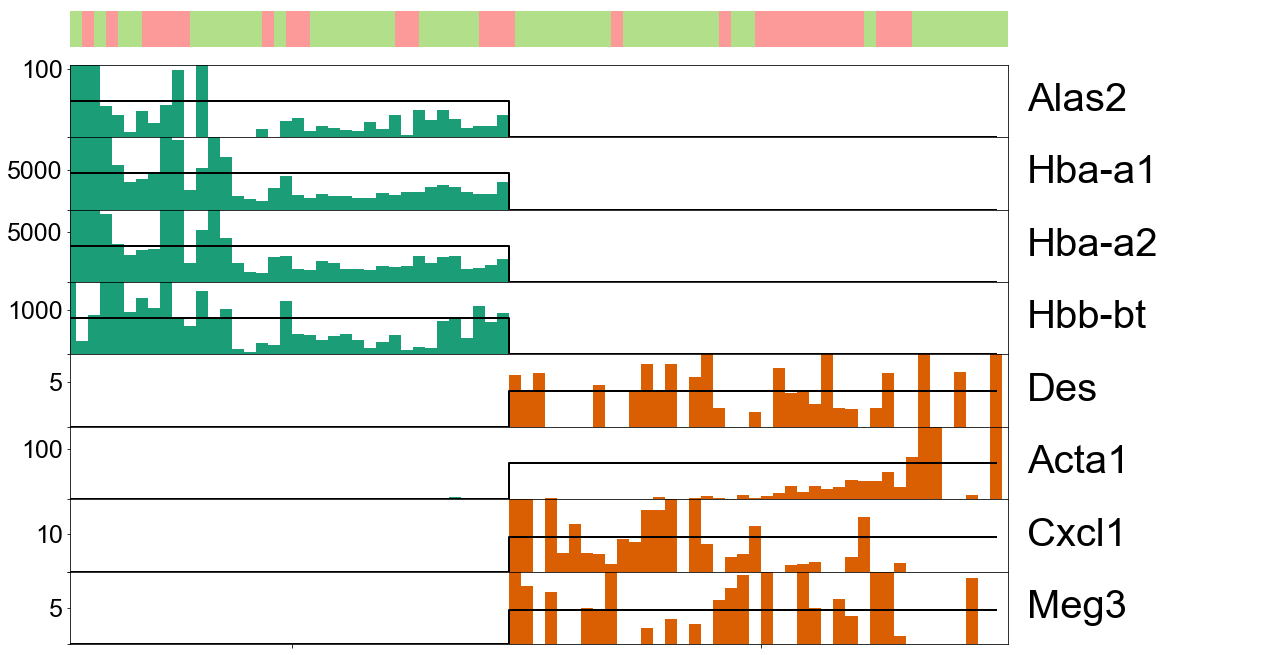

In [39]:
cell_groups = cl_c_MISC
dataset = seqN[cl_c_MISC.index]
#genes = ['Des']
cmap = cmap_2nd

#create figure

bar_size = 0.5
bar_pad = 0.25
width = 17.5
height = len(genes) * 1.1

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#create GS for gene barplots

gs1 = plt.GridSpec(len(genes), 2, hspace = 0.00, wspace = 0.0, top = 1 - ((bar_pad + bar_size) / height), right = 1, 
                   left = (bar_pad + bar_size) / width, bottom = 0, width_ratios = [14,4])

#create GS for sample group bar

gs0 = plt.GridSpec(1,2, left = (bar_pad + bar_size) / width, right = 1, top = 1,
                       bottom = 1 - ((bar_size) / height), hspace = 0.0, wspace = 0.0, width_ratios = [14,4])

#colorlist bar

clistBAR = [cmap[val] for val in cell_groups]

#draw genes

for g in genes:
    
        #create group_specific mean expressions
    
        mean_tmp = pd.Series(index = set(cell_groups))
        
        for gr in set(cell_groups):
            
            ix_tmp = cell_groups[cell_groups == gr].index
            mean_tmp[gr] = dataset.ix[g, ix_tmp].mean()
            
        #create white space for gene names
        
        ax0 = plt.subplot(gs1[genes.index(g),1])
        clean_axis(ax0)
 
        #create axis
            
        ax0 = plt.subplot(gs1[genes.index(g),0])
        
        ax0.axvspan(0, len(dataset.columns), color = '#FFFFFF', zorder = 0)
        
        #define xaxis
        
        ax0.set_xlim(left = 0, right = (len(dataset.columns)))
        ax0.xaxis.set_ticks(get_cluster_ticks(cell_groups))
        ax0.xaxis.set_ticklabels([])
        
        #define yaxis
        
        ax0.set_ylim(bottom = 0, top = np.ceil(np.max(mean_tmp) * 2))
        ax0.set_ylabel(g, family = 'Arial', fontsize = 40, rotation = 'horizontal', va = 'center', ha = 'left')
        ax0.yaxis.set_label_coords(1.02, 0.5)
        
        ax0.locator_params(axis='y', nbins=2)
        
        for tick_pos, tick in enumerate(ax0.yaxis.get_major_ticks()):
            if tick_pos % 2 == 1:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)
            else:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_visible(False)
                
        #draw expression data
        
        ax0.bar(np.arange(0, len(dataset.columns),1), dataset.ix[g], color = clistBAR, linewidth = 0, width = 1.0)
        
        #draw means
        
        ax0.step(range(len(cell_groups)), [mean_tmp[val] for val in cell_groups], where = 'mid', color = 'black', linewidth = 2)

ax1 = plt.subplot(gs0[0,0])

ax1.set_xlim(0, len(cell_groups))

for pos, c in enumerate(cell_groups.index):
    
    ax1.axvspan(xmin = pos, xmax = pos + 1, color = cmap_time[cells_stage[c]])

remove_ticks(ax1, linewidth = 1)
clean_axis(ax1)

figname = 'v1.5_Fig6_bar_MISC.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Differentially expressed genes

In [66]:
def MWU_get_binarized(mwu_pval, cutoff, neglog = True):
    
    output = pd.DataFrame(index = mwu_pval.index, columns = mwu_pval.columns).fillna(0)
    
    if neglog == True:
        output[mwu_pval>=cutoff] = 1
    else:
        output[mwu_pval<cutoff] = 1
    
    return output

In [67]:
def MWU_extract_genes_(mwu_pval, mwu_bin, number = 10, neglog = True):
    
    output = pd.DataFrame(index = range(number), columns = mwu_bin.columns).fillna('None')
    
    for gr in mwu_bin.columns:
        g_bin = mwu_bin[gr][mwu_bin[gr]==1].index
        
        if neglog == True:
            g_sel = mwu_pval.loc[g_bin, gr].sort_values()[-number:].index[::-1]
            #return g_sel
        else:
            g_sel = mwu_pval.loc[g_bin, gr].sort_values()[number:].index
            
        output.loc[range(len(g_sel)), gr] = g_sel
        
    return output

## Immune cells

In [68]:
MWU_av_IMM = loadData_v1(path_output, exp_id, 'MWU_av_IMM','DataFrame')
MWU_gr_IMM = loadData_v1(path_output, exp_id, 'MWU_gr_IMM','DataFrame')

In [69]:
MWU_av_IMM[MWU_av_IMM==np.inf] = 307
MWU_gr_IMM[MWU_gr_IMM==np.inf] = 307

In [70]:
MWU_av_IMM_bin = MWU_get_binarized(MWU_av_IMM, -np.log10(0.001), neglog = True)
MWU_gr_IMM_bin = MWU_get_binarized(MWU_gr_IMM, -np.log10(0.001), neglog = True)

In [71]:
MWU_av_IMM_genes = MWU_extract_genes_(MWU_av_IMM, MWU_av_IMM_bin, number = 10, neglog = True)
MWU_gr_IMM_genes = MWU_extract_genes_(MWU_gr_IMM, MWU_gr_IMM_bin, number = 10, neglog = True)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize

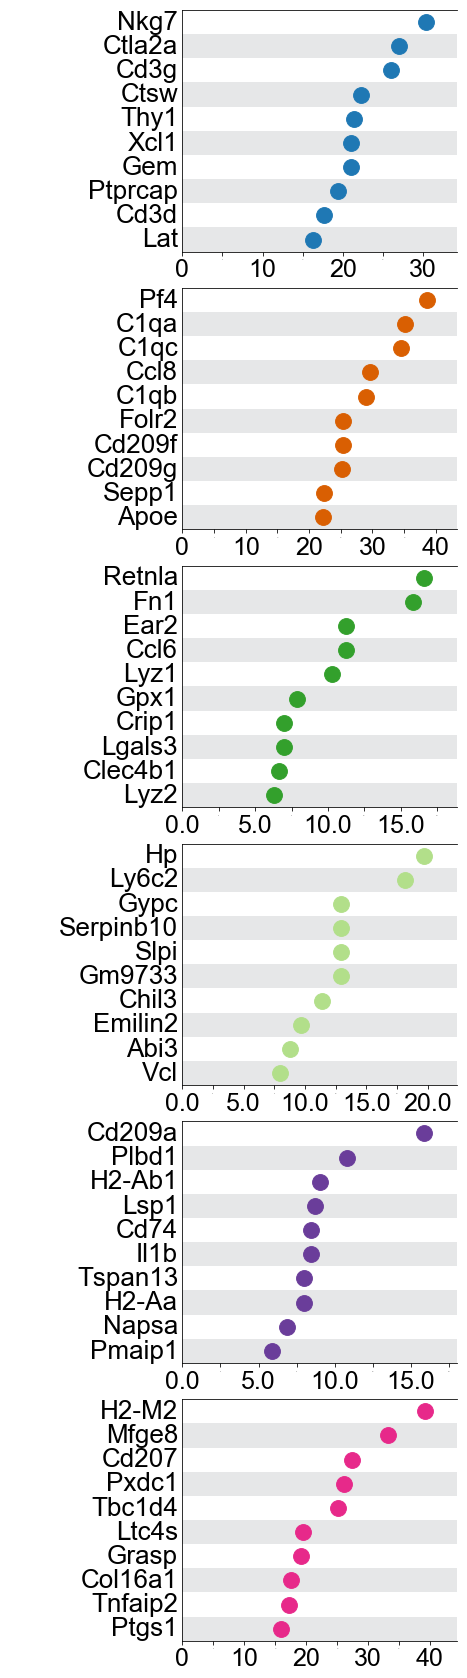

In [144]:
#define input variables

gr_order = return_unique(cl_c_IMM)
genes = MWU_av_IMM_genes
L = len(genes.index)
pval = MWU_av_IMM
cmap = cmap_2nd

#initialize figure

height = 5 * len(gr_order)
width = 8

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(len(gr_order), 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#iterate through groups

for pos, gr in enumerate(gr_order):
    
    genes_tmp = [gene for gene in genes[gr].values if gene != 'None']
    
    #create gene name axis 
    
    ax0 = plt.subplot(gs[pos,0])
    ax0.set_ylim(L - 0.5, -0.5)
    clean_axis(ax0)
    
    #create violin plot axis
    
    ax1 = plt.subplot(gs[pos,1])
    
    ax1.spines['right'].set_color('none')

    ax1.set_ylim(L - 0.5, -0.5)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_ticks([])
    
    #iterate over genes
    
    for ix, g in enumerate(genes_tmp):
        ax0.text(0.975, ix, g, family = 'Arial', fontsize = 26, ha = 'right', va = 'center')
        
        #print background
        
        if ix % 2 == 0:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
        if ix % 2 == 1:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
            
        #print pvals
        
        ax1.scatter(pval.loc[g,gr], ix, marker = 'o', s = 250, color = cmap[gr])
        
    xlim = list(ax1.get_xlim())

    ax1.set_xlim(0, xlim[1] * 1.1)

    for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
        if ix % 2 == 0:
            t.set_family('Arial')
            t.set_fontsize(25)
        else:
            t.set_fontsize(0)
            
figname = 'v1.5_FigS8_MWU_vs_av_IMM.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


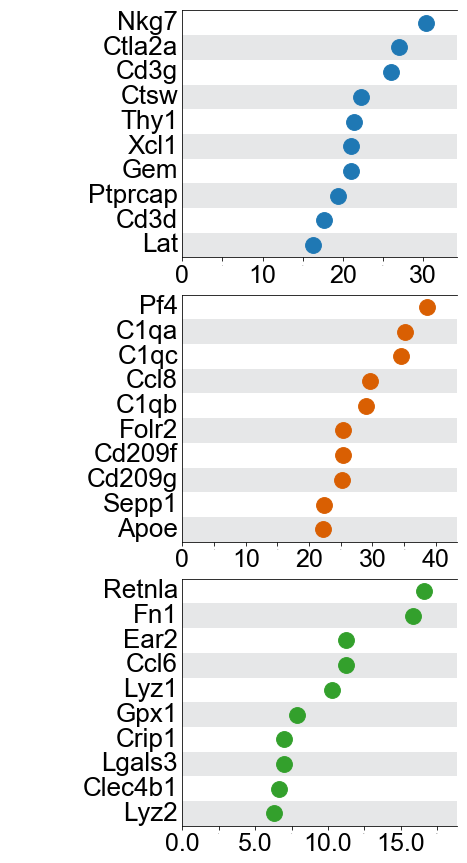

In [72]:
#define input variables

gr_order = return_unique(cl_c_IMM)[:3]
genes = MWU_av_IMM_genes
L = len(genes.index)
pval = MWU_av_IMM
cmap = cmap_2nd

#initialize figure

height = 5 * len(gr_order)
width = 8

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(len(gr_order), 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#iterate through groups

for pos, gr in enumerate(gr_order):
    
    genes_tmp = [gene for gene in genes[gr].values if gene != 'None']
    
    #create gene name axis 
    
    ax0 = plt.subplot(gs[pos,0])
    ax0.set_ylim(L - 0.5, -0.5)
    clean_axis(ax0)
    
    #create violin plot axis
    
    ax1 = plt.subplot(gs[pos,1])
    
    ax1.spines['right'].set_color('none')

    ax1.set_ylim(L - 0.5, -0.5)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_ticks([])
    
    #iterate over genes
    
    for ix, g in enumerate(genes_tmp):
        ax0.text(0.975, ix, g, family = 'Arial', fontsize = 26, ha = 'right', va = 'center')
        
        #print background
        
        if ix % 2 == 0:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
        if ix % 2 == 1:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
            
        #print pvals
        
        ax1.scatter(pval.loc[g,gr], ix, marker = 'o', s = 250, color = cmap[gr])
        
    xlim = list(ax1.get_xlim())

    ax1.set_xlim(0, xlim[1] * 1.1)

    for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
        if ix % 2 == 0:
            t.set_family('Arial')
            t.set_fontsize(25)
        else:
            t.set_fontsize(0)
            
figname = 'v1.5_FigS8_MWU_vs_av_IMM1.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize

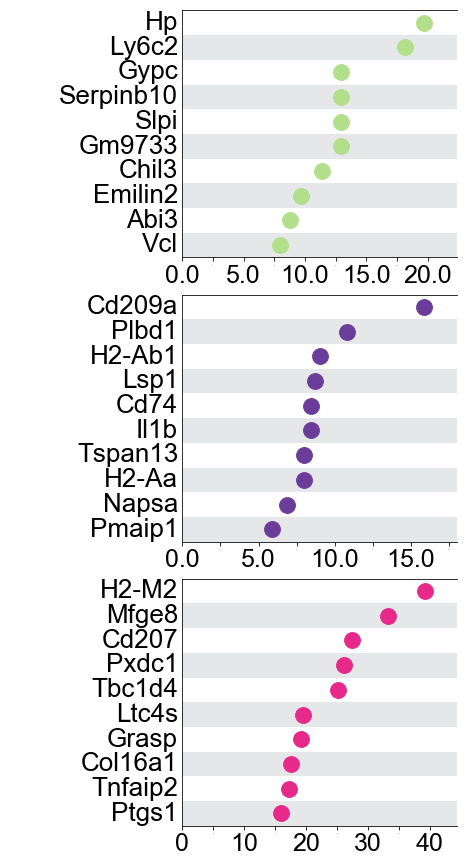

In [73]:
#define input variables

gr_order = return_unique(cl_c_IMM)[3:]
genes = MWU_av_IMM_genes
L = len(genes.index)
pval = MWU_av_IMM
cmap = cmap_2nd

#initialize figure

height = 5 * len(gr_order)
width = 8

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(len(gr_order), 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#iterate through groups

for pos, gr in enumerate(gr_order):
    
    genes_tmp = [gene for gene in genes[gr].values if gene != 'None']
    
    #create gene name axis 
    
    ax0 = plt.subplot(gs[pos,0])
    ax0.set_ylim(L - 0.5, -0.5)
    clean_axis(ax0)
    
    #create violin plot axis
    
    ax1 = plt.subplot(gs[pos,1])
    
    ax1.spines['right'].set_color('none')

    ax1.set_ylim(L - 0.5, -0.5)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_ticks([])
    
    #iterate over genes
    
    for ix, g in enumerate(genes_tmp):
        ax0.text(0.975, ix, g, family = 'Arial', fontsize = 26, ha = 'right', va = 'center')
        
        #print background
        
        if ix % 2 == 0:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
        if ix % 2 == 1:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
            
        #print pvals
        
        ax1.scatter(pval.loc[g,gr], ix, marker = 'o', s = 250, color = cmap[gr])
        
    xlim = list(ax1.get_xlim())

    ax1.set_xlim(0, xlim[1] * 1.1)

    for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
        if ix % 2 == 0:
            t.set_family('Arial')
            t.set_fontsize(25)
        else:
            t.set_fontsize(0)
            
figname = 'v1.5_FigS8_MWU_vs_av_IMM2.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Vascular cells

In [74]:
MWU_av_VASC = loadData_v1(path_output, exp_id, 'MWU_av_VASC','DataFrame')
MWU_gr_VASC = loadData_v1(path_output, exp_id, 'MWU_gr_VASC','DataFrame')

In [75]:
MWU_av_VASC[MWU_av_VASC==np.inf] = 307
MWU_gr_VASC[MWU_gr_VASC==np.inf] = 307

In [76]:
MWU_av_VASC_bin = MWU_get_binarized(MWU_av_VASC, -np.log10(0.001), neglog = True)
MWU_gr_VASC_bin = MWU_get_binarized(MWU_gr_VASC, -np.log10(0.001), neglog = True)

In [77]:
MWU_av_VASC_genes = MWU_extract_genes_(MWU_av_VASC, MWU_av_VASC_bin, number = 10, neglog = True)
MWU_gr_VASC_genes = MWU_extract_genes_(MWU_gr_VASC, MWU_gr_VASC_bin, number = 10, neglog = True)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


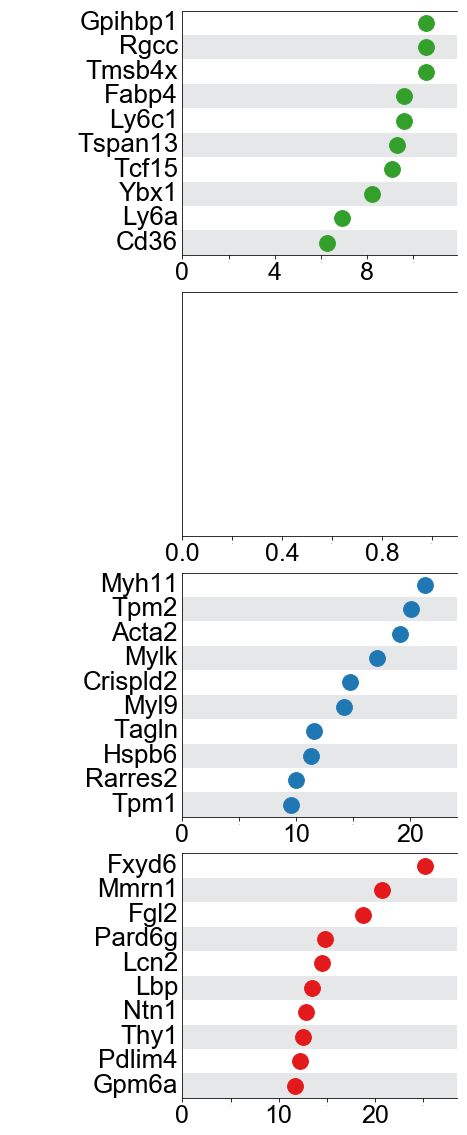

In [78]:
#define input variables

gr_order = return_unique(cl_c_VASC)
genes = MWU_av_VASC_genes
L = len(genes.index)
pval = MWU_av_VASC
cmap = cmap_2nd

#initialize figure

height = 5 * len(gr_order)
width = 8

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(len(gr_order), 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#iterate through groups

for pos, gr in enumerate(gr_order):
    
    genes_tmp = [gene for gene in genes[gr].values if gene != 'None']
    
    #create gene name axis 
    
    ax0 = plt.subplot(gs[pos,0])
    ax0.set_ylim(L - 0.5, -0.5)
    clean_axis(ax0)
    
    #create violin plot axis
    
    ax1 = plt.subplot(gs[pos,1])
    
    ax1.spines['right'].set_color('none')

    ax1.set_ylim(L - 0.5, -0.5)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_ticks([])
    
    #iterate over genes
    
    for ix, g in enumerate(genes_tmp):
        ax0.text(0.975, ix, g, family = 'Arial', fontsize = 26, ha = 'right', va = 'center')
        
        #print background
        
        if ix % 2 == 0:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
        if ix % 2 == 1:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
            
        #print pvals
        
        ax1.scatter(pval.loc[g,gr], ix, marker = 'o', s = 250, color = cmap[gr])
        
    xlim = list(ax1.get_xlim())

    ax1.set_xlim(0, xlim[1] * 1.1)

    for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
        if ix % 2 == 0:
            t.set_family('Arial')
            t.set_fontsize(25)
        else:
            t.set_fontsize(0)
            
figname = 'v1.5_FigS8_MWU_vs_av_VASC.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Neural crest cells

In [79]:
MWU_av_MEL = loadData_v1(path_output, exp_id, 'MWU_av_MEL','DataFrame')
MWU_gr_MEL = loadData_v1(path_output, exp_id, 'MWU_gr_MEL','DataFrame')

In [80]:
MWU_av_MEL[MWU_av_MEL==np.inf] = 307
MWU_gr_MEL[MWU_gr_MEL==np.inf] = 307

In [81]:
MWU_av_MEL_bin = MWU_get_binarized(MWU_av_MEL, -np.log10(0.001), neglog = True)
MWU_gr_MEL_bin = MWU_get_binarized(MWU_gr_MEL, -np.log10(0.001), neglog = True)

In [82]:
MWU_av_MEL_genes = MWU_extract_genes_(MWU_av_MEL, MWU_av_MEL_bin, number = 10, neglog = True)
MWU_gr_MEL_genes = MWU_extract_genes_(MWU_gr_MEL, MWU_gr_MEL_bin, number = 10, neglog = True)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


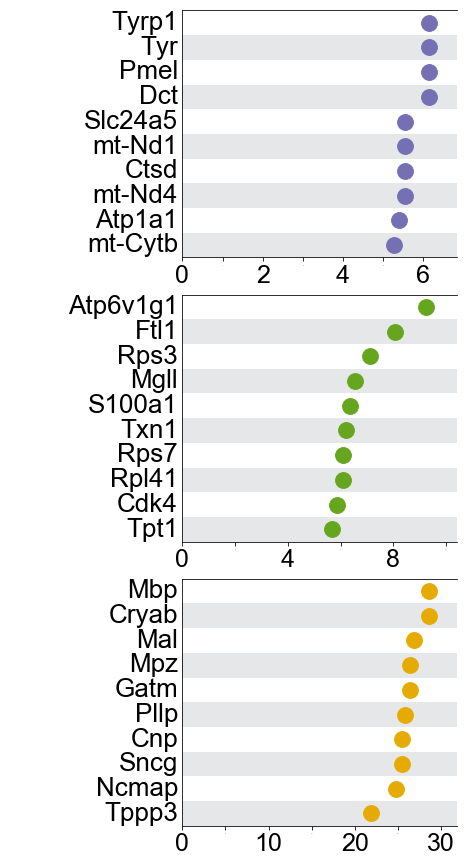

In [83]:
#define input variables

gr_order = return_unique(cl_c_MEL)
genes = MWU_av_MEL_genes
L = len(genes.index)
pval = MWU_av_MEL
cmap = cmap_2nd

#initialize figure

height = 5 * len(gr_order)
width = 8

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(len(gr_order), 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#iterate through groups

for pos, gr in enumerate(gr_order):
    
    genes_tmp = [gene for gene in genes[gr].values if gene != 'None']
    
    #create gene name axis 
    
    ax0 = plt.subplot(gs[pos,0])
    ax0.set_ylim(L - 0.5, -0.5)
    clean_axis(ax0)
    
    #create violin plot axis
    
    ax1 = plt.subplot(gs[pos,1])
    
    ax1.spines['right'].set_color('none')

    ax1.set_ylim(L - 0.5, -0.5)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_ticks([])
    
    #iterate over genes
    
    for ix, g in enumerate(genes_tmp):
        ax0.text(0.975, ix, g, family = 'Arial', fontsize = 26, ha = 'right', va = 'center')
        
        #print background
        
        if ix % 2 == 0:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
        if ix % 2 == 1:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
            
        #print pvals
        
        ax1.scatter(pval.loc[g,gr], ix, marker = 'o', s = 250, color = cmap[gr])
        
    xlim = list(ax1.get_xlim())

    ax1.set_xlim(0, xlim[1] * 1.1)

    for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
        if ix % 2 == 0:
            t.set_family('Arial')
            t.set_fontsize(25)
        else:
            t.set_fontsize(0)
            
figname = 'v1.5_FigS8_MWU_vs_av_MEL.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Miscellaneous 

In [84]:
MWU_av_MISC = loadData_v1(path_output, exp_id, 'MWU_av_MISC','DataFrame')
MWU_gr_MISC = loadData_v1(path_output, exp_id, 'MWU_gr_MISC','DataFrame')

In [85]:
MWU_av_MISC[MWU_av_MISC==np.inf] = 307
MWU_gr_MISC[MWU_gr_MISC==np.inf] = 307

In [86]:
MWU_av_MISC_bin = MWU_get_binarized(MWU_av_MISC, -np.log10(0.001), neglog = True)
MWU_gr_MISC_bin = MWU_get_binarized(MWU_gr_MISC, -np.log10(0.001), neglog = True)

In [87]:
MWU_av_MISC_genes = MWU_extract_genes_(MWU_av_MISC, MWU_av_MISC_bin, number = 10, neglog = True)
MWU_gr_MISC_genes = MWU_extract_genes_(MWU_gr_MISC, MWU_gr_MISC_bin, number = 10, neglog = True)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


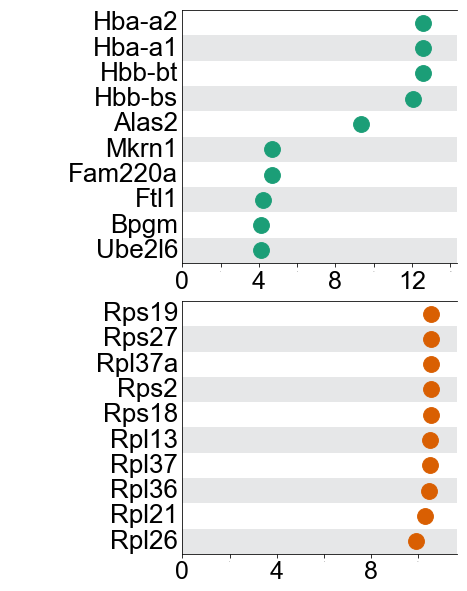

In [88]:
#define input variables

gr_order = return_unique(cl_c_MISC)
genes = MWU_av_MISC_genes
L = len(genes.index)
pval = MWU_av_MISC
cmap = cmap_2nd

#initialize figure

height = 5 * len(gr_order)
width = 8

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(len(gr_order), 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#iterate through groups

for pos, gr in enumerate(gr_order):
    
    genes_tmp = [gene for gene in genes[gr].values if gene != 'None']
    
    #create gene name axis 
    
    ax0 = plt.subplot(gs[pos,0])
    ax0.set_ylim(L - 0.5, -0.5)
    clean_axis(ax0)
    
    #create violin plot axis
    
    ax1 = plt.subplot(gs[pos,1])
    
    ax1.spines['right'].set_color('none')

    ax1.set_ylim(L - 0.5, -0.5)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_ticks([])
    
    #iterate over genes
    
    for ix, g in enumerate(genes_tmp):
        ax0.text(0.975, ix, g, family = 'Arial', fontsize = 26, ha = 'right', va = 'center')
        
        #print background
        
        if ix % 2 == 0:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
        if ix % 2 == 1:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
            
        #print pvals
        
        ax1.scatter(pval.loc[g,gr], ix, marker = 'o', s = 250, color = cmap[gr])
        
    xlim = list(ax1.get_xlim())

    ax1.set_xlim(0, xlim[1] * 1.1)

    for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
        if ix % 2 == 0:
            t.set_family('Arial')
            t.set_fontsize(25)
        else:
            t.set_fontsize(0)
            
figname = 'v1.5_FigS8_MWU_vs_av_MISC.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Cell-cell-distance

In [89]:
seq_sel_IMM = loadData_v1(path_output, exp_id, 'seq_sel_IMM', 'DataFrame')

In [90]:
seq_sel_IMM_pca, dist_c_IMM = dim_reduc_pca(seq_sel_IMM, 15, 'euclidean', inverse_transform = False)

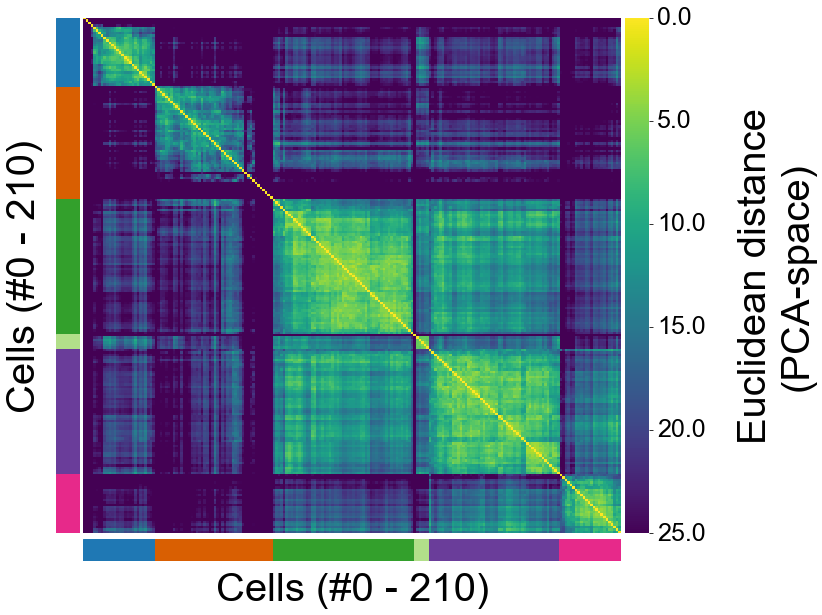

In [91]:
groups = cl_c_IMM
dist = dist_c_IMM
dist = dist.loc[groups.index, groups.index]
vmin = 0
vmax = 25
cmap = plt.cm.viridis_r
cmap_groups = cmap_2nd

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (10.625, 10))
gs = plt.GridSpec(nrows = 2, ncols = 3, wspace=0.02, hspace=0.02, width_ratios=[0.5 , 11.25, 0.5], height_ratios=[11.25, 0.5])

#plot heatmap

axHM = plt.subplot(gs[0, 1])

axHM.matshow(dist, cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax, interpolation = None)
    
axHM.set_xlabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)
axHM.set_ylabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)

axHM.xaxis.set_label_coords(0.5, -0.075)
axHM.yaxis.set_label_coords(-0.075, 0.5)
    
axHM.set_yticks([])

clean_axis(axHM)

#plot left sample groups

axSG1 = plt.subplot(gs[0, 0])

axSG1.set_ylim(len(groups), 0)

for pos, gr in enumerate(groups):
    axSG1.axhspan(pos, pos+1, color=cmap_groups[gr])
    
remove_ticks(axSG1)
clean_axis(axSG1)

#plot bottom sample groups

axSG2 = plt.subplot(gs[1, 1])

axSG2.set_xlim(0, len(groups))

for pos, gr in enumerate(groups):
    axSG2.axvspan(pos, pos+1, color=cmap_groups[gr])

remove_ticks(axSG2)
clean_axis(axSG2)

#plot label

axLabel = plt.subplot(gs[0,2])

axLabel.matshow(np.matrix(np.arange(vmin, vmax, 0.1)).T,
                cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks(np.linspace(axLabel.get_ylim()[0], axLabel.get_ylim()[1], 6))
axLabel.set_yticklabels(np.linspace(vmax, vmin, 6), family = 'Arial', fontsize = 25, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=5)

axLabel.set_ylabel('Euclidean distance\n(PCA-space)', family = 'Arial', fontsize = 40)
axLabel.yaxis.set_label_coords(8, 0.5)

figname = 'v1.5_FigS8_cell_cell_distance_IMM.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

In [92]:
seq_sel_VASC = loadData_v1(path_output, exp_id, 'seq_sel_VASC', 'DataFrame')

In [93]:
seq_sel_VASC_pca, dist_c_VASC = dim_reduc_pca(seq_sel_VASC, 8, 'euclidean', inverse_transform = False)

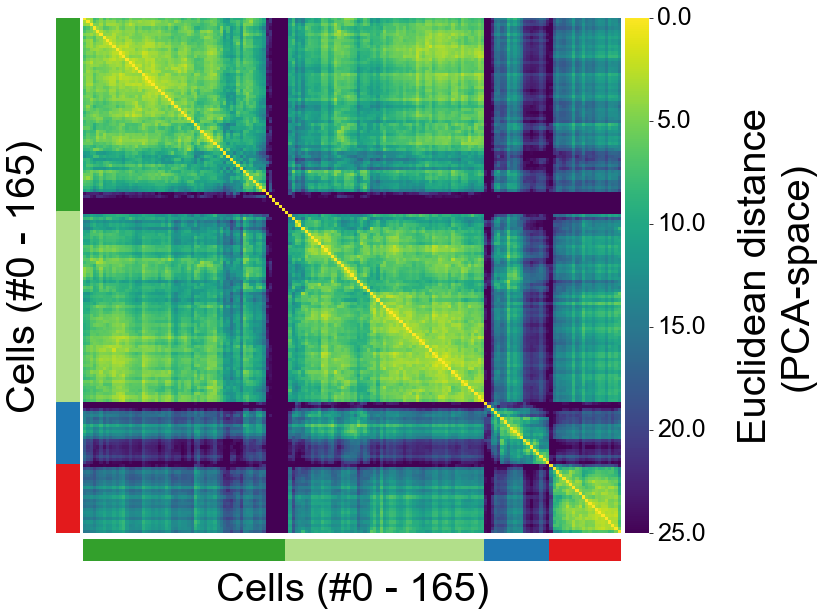

In [94]:
groups = cl_c_VASC
dist = dist_c_VASC
dist = dist.loc[groups.index, groups.index]
vmin = 0
vmax = 25
cmap = plt.cm.viridis_r
cmap_groups = cmap_2nd

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (10.625, 10))
gs = plt.GridSpec(nrows = 2, ncols = 3, wspace=0.02, hspace=0.02, width_ratios=[0.5 , 11.25, 0.5], height_ratios=[11.25, 0.5])

#plot heatmap

axHM = plt.subplot(gs[0, 1])

axHM.matshow(dist, cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax, interpolation = None)
    
axHM.set_xlabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)
axHM.set_ylabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)

axHM.xaxis.set_label_coords(0.5, -0.075)
axHM.yaxis.set_label_coords(-0.075, 0.5)
    
axHM.set_yticks([])

clean_axis(axHM)

#plot left sample groups

axSG1 = plt.subplot(gs[0, 0])

axSG1.set_ylim(len(groups), 0)

for pos, gr in enumerate(groups):
    axSG1.axhspan(pos, pos+1, color=cmap_groups[gr])
    
remove_ticks(axSG1)
clean_axis(axSG1)

#plot bottom sample groups

axSG2 = plt.subplot(gs[1, 1])

axSG2.set_xlim(0, len(groups))

for pos, gr in enumerate(groups):
    axSG2.axvspan(pos, pos+1, color=cmap_groups[gr])

remove_ticks(axSG2)
clean_axis(axSG2)

#plot label

axLabel = plt.subplot(gs[0,2])

axLabel.matshow(np.matrix(np.arange(vmin, vmax, 0.1)).T,
                cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks(np.linspace(axLabel.get_ylim()[0], axLabel.get_ylim()[1], 6))
axLabel.set_yticklabels(np.linspace(vmax, vmin, 6), family = 'Arial', fontsize = 25, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=5)

axLabel.set_ylabel('Euclidean distance\n(PCA-space)', family = 'Arial', fontsize = 40)
axLabel.yaxis.set_label_coords(8, 0.5)

figname = 'v1.5_FigS8_cell_cell_distance_VASC.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

In [95]:
seq_sel_MEL = loadData_v1(path_output, exp_id, 'seq_sel_MEL', 'DataFrame')

In [96]:
seq_sel_MEL_pca, dist_c_MEL = dim_reduc_pca(seq_sel_MEL, 15, 'euclidean', inverse_transform = False)

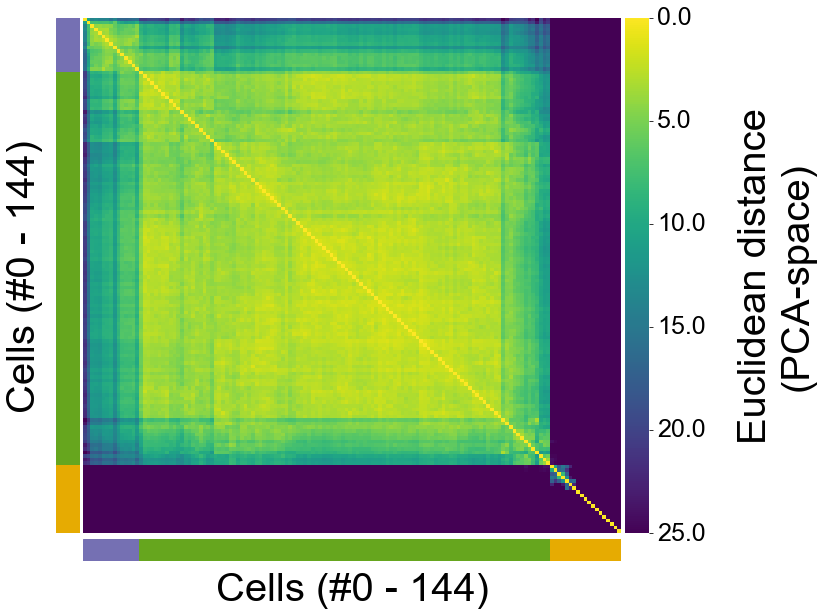

In [97]:
groups = cl_c_MEL
dist = dist_c_MEL
dist = dist.loc[groups.index, groups.index]
vmin = 0
vmax = 25
cmap = plt.cm.viridis_r
cmap_groups = cmap_2nd

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (10.625, 10))
gs = plt.GridSpec(nrows = 2, ncols = 3, wspace=0.02, hspace=0.02, width_ratios=[0.5 , 11.25, 0.5], height_ratios=[11.25, 0.5])

#plot heatmap

axHM = plt.subplot(gs[0, 1])

axHM.matshow(dist, cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax, interpolation = None)
    
axHM.set_xlabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)
axHM.set_ylabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)

axHM.xaxis.set_label_coords(0.5, -0.075)
axHM.yaxis.set_label_coords(-0.075, 0.5)
    
axHM.set_yticks([])

clean_axis(axHM)

#plot left sample groups

axSG1 = plt.subplot(gs[0, 0])

axSG1.set_ylim(len(groups), 0)

for pos, gr in enumerate(groups):
    axSG1.axhspan(pos, pos+1, color=cmap_groups[gr])
    
remove_ticks(axSG1)
clean_axis(axSG1)

#plot bottom sample groups

axSG2 = plt.subplot(gs[1, 1])

axSG2.set_xlim(0, len(groups))

for pos, gr in enumerate(groups):
    axSG2.axvspan(pos, pos+1, color=cmap_groups[gr])

remove_ticks(axSG2)
clean_axis(axSG2)

#plot label

axLabel = plt.subplot(gs[0,2])

axLabel.matshow(np.matrix(np.arange(vmin, vmax, 0.1)).T,
                cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks(np.linspace(axLabel.get_ylim()[0], axLabel.get_ylim()[1], 6))
axLabel.set_yticklabels(np.linspace(vmax, vmin, 6), family = 'Arial', fontsize = 25, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=5)

axLabel.set_ylabel('Euclidean distance\n(PCA-space)', family = 'Arial', fontsize = 40)
axLabel.yaxis.set_label_coords(8, 0.5)

figname = 'v1.5_FigS8_cell_cell_distance_MEL.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

In [98]:
seq_sel_MISC = loadData_v1(path_output, exp_id, 'seq_sel_MISC', 'DataFrame')

In [99]:
seq_sel_MISC_pca, dist_c_MISC = dim_reduc_pca(seq_sel_MISC, 10, 'euclidean', inverse_transform = False)

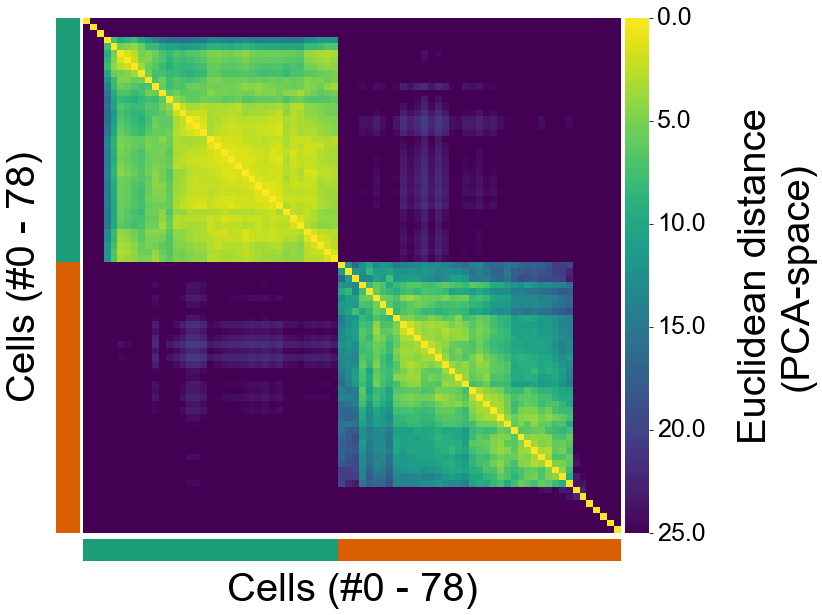

In [100]:
groups = cl_c_MISC
dist = dist_c_MISC
dist = dist.loc[groups.index, groups.index]
vmin = 0
vmax = 25
cmap = plt.cm.viridis_r
cmap_groups = cmap_2nd

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (10.625, 10))
gs = plt.GridSpec(nrows = 2, ncols = 3, wspace=0.02, hspace=0.02, width_ratios=[0.5 , 11.25, 0.5], height_ratios=[11.25, 0.5])

#plot heatmap

axHM = plt.subplot(gs[0, 1])

axHM.matshow(dist, cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax, interpolation = None)
    
axHM.set_xlabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)
axHM.set_ylabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)

axHM.xaxis.set_label_coords(0.5, -0.075)
axHM.yaxis.set_label_coords(-0.075, 0.5)
    
axHM.set_yticks([])

clean_axis(axHM)

#plot left sample groups

axSG1 = plt.subplot(gs[0, 0])

axSG1.set_ylim(len(groups), 0)

for pos, gr in enumerate(groups):
    axSG1.axhspan(pos, pos+1, color=cmap_groups[gr])
    
remove_ticks(axSG1)
clean_axis(axSG1)

#plot bottom sample groups

axSG2 = plt.subplot(gs[1, 1])

axSG2.set_xlim(0, len(groups))

for pos, gr in enumerate(groups):
    axSG2.axvspan(pos, pos+1, color=cmap_groups[gr])

remove_ticks(axSG2)
clean_axis(axSG2)

#plot label

axLabel = plt.subplot(gs[0,2])

axLabel.matshow(np.matrix(np.arange(vmin, vmax, 0.1)).T,
                cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks(np.linspace(axLabel.get_ylim()[0], axLabel.get_ylim()[1], 6))
axLabel.set_yticklabels(np.linspace(vmax, vmin, 6), family = 'Arial', fontsize = 25, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=5)

axLabel.set_ylabel('Euclidean distance\n(PCA-space)', family = 'Arial', fontsize = 40)
axLabel.yaxis.set_label_coords(8, 0.5)

figname = 'v1.5_FigS8_cell_cell_distance_MISC.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Comparison to Seurat

In [41]:
cl_c_IMM_S = pd.read_csv('%s/Seurat/TenX_2ndLevel_IMM_ClusterIdentity.txt' % path_output, sep = '\t', header = None, index_col = 0, 
                           low_memory = False, squeeze = True)

In [42]:
tsne_IMM_S = pd.read_csv('%s/Seurat/TenX_2ndLevel_IMM_TSNEcoordinates.txt' % path_output, sep = '\t', index_col = 0, header = 0)
tsne_IMM_S.columns = ['x','y']

In [43]:
c_sel_IMM = list(set(cl_c_IMM_S.index) & set(cl_c_IMM.index))
cl_c_IMM_S = AP_groups_reorder_v2(cl_c_IMM_S[c_sel_IMM], [3,2,1,0,4])

In [44]:
cmap_IMM_S = {3:'#1f78b4',2:'#d95f02',1:'#33a02c',0:'#6a3d9a',4:'#e7298a'}

In [45]:
cl_c_VASC_S = pd.read_csv('%s/Seurat/TenX_2ndLevel_VASC_ClusterIdentity.txt' % path_output, sep = '\t', header = None, index_col = 0, 
                           low_memory = False, squeeze = True)

In [46]:
tsne_VASC_S = pd.read_csv('%s/Seurat/TenX_2ndLevel_VASC_TSNEcoordinates.txt' % path_output, sep = '\t', index_col = 0, header = 0)
tsne_VASC_S.columns = ['x','y']

In [47]:
c_sel_VASC = list(set(cl_c_VASC_S.index) & set(cl_c_VASC.index))
cl_c_VASC_S = AP_groups_reorder_v2(cl_c_VASC_S[c_sel_VASC], [0,1,2,3])

In [48]:
cmap_VASC_S = {0:'#33a02c',2:'#1f78b4',1:'#b2df8a',3:'#e31a1c'}

In [49]:
cl_c_MEL_S = pd.read_csv('%s/Seurat/TenX_2ndLevel_MEL_ClusterIdentity.txt' % path_output, sep = '\t', header = None, index_col = 0, 
                           low_memory = False, squeeze = True)

In [50]:
tsne_MEL_S = pd.read_csv('%s/Seurat/TenX_2ndLevel_MEL_TSNEcoordinates.txt' % path_output, sep = '\t', index_col = 0, header = 0)
tsne_MEL_S.columns = ['x','y']

In [51]:
c_sel_MEL = list(set(cl_c_MEL_S.index) & set(cl_c_MEL.index))
cl_c_MEL_S = AP_groups_reorder_v2(cl_c_MEL_S[c_sel_MEL], [2,1,0,3])

In [52]:
cmap_MEL_S = {2:'#1b9e77',1:'#d95f02',0:'#7570b3',3:'#e7298a'}

In [53]:
cl_c_MISC_S = pd.read_csv('%s/Seurat/TenX_2ndLevel_MISC_ClusterIdentity.txt' % path_output, sep = '\t', header = None, index_col = 0, 
                           low_memory = False, squeeze = True)

In [54]:
tsne_MISC_S = pd.read_csv('%s/Seurat/TenX_2ndLevel_MISC_TSNEcoordinates.txt' % path_output, sep = '\t', index_col = 0, header = 0)
tsne_MISC_S.columns = ['x','y']

In [55]:
c_sel_MISC = list(set(cl_c_MISC_S.index) & set(cl_c_MISC.index))
cl_c_MISC_S = AP_groups_reorder_v2(cl_c_MISC_S[c_sel_MISC], [1,0])

In [56]:
cmap_MISC_S = {0:'#d95f02',1:'#1b9e77'}

## tSNE

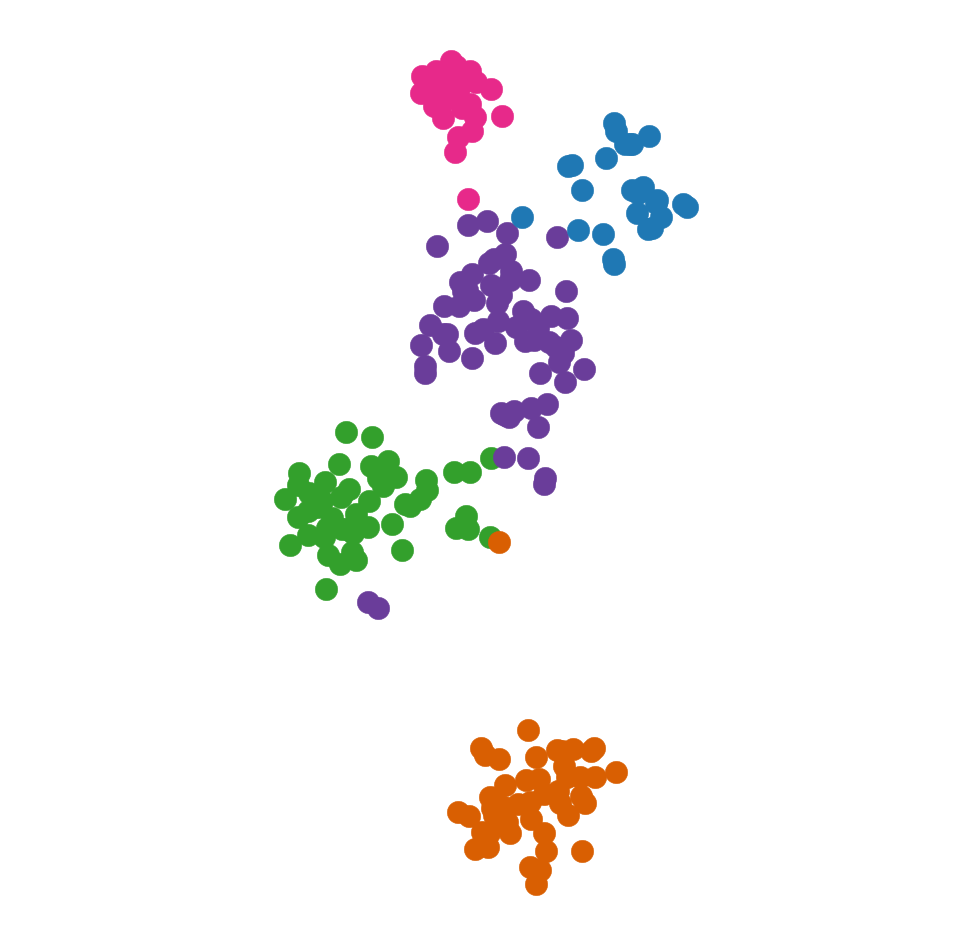

In [117]:
cells = cl_c_IMM_S
tsne = tsne_IMM_S.loc[cells.index]
cmap = cmap_IMM_S
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 500,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_FigS8_tSNE_IMM_Seurat.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

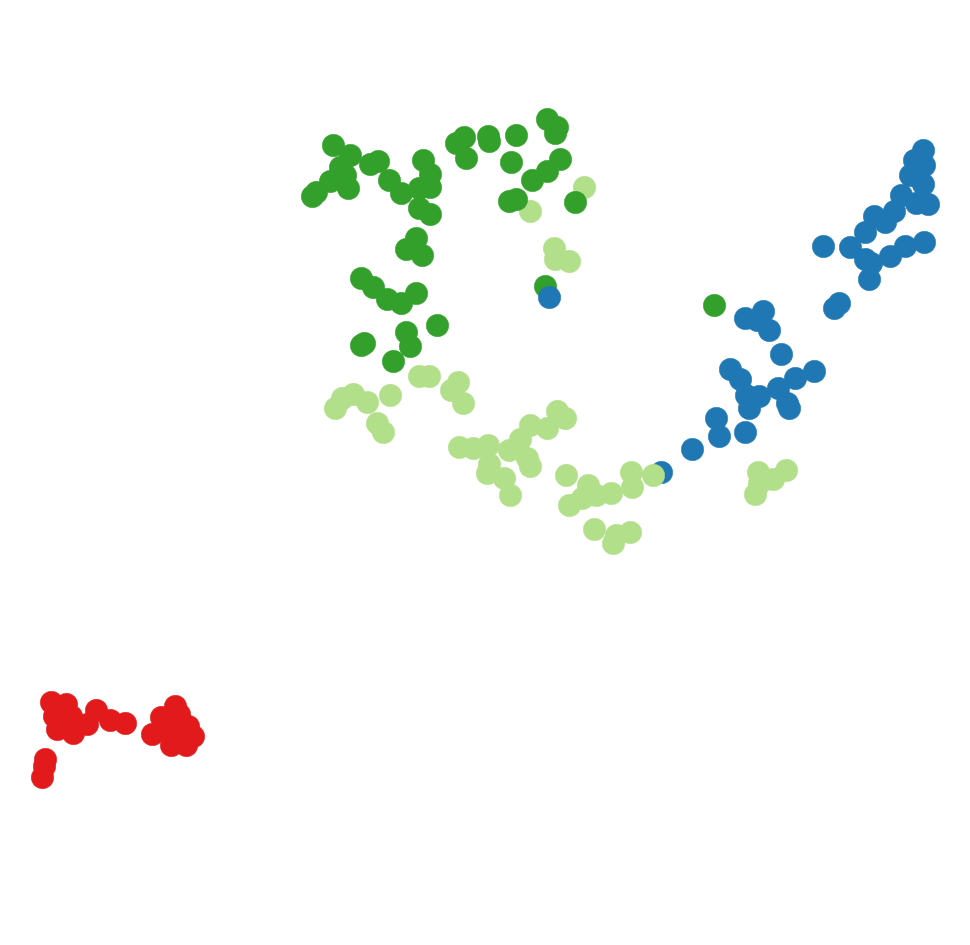

In [118]:
cells = cl_c_VASC_S
tsne = tsne_VASC_S.loc[cells.index]
cmap = cmap_VASC_S
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 500,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_FigS8_tSNE_VASC_Seurat.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

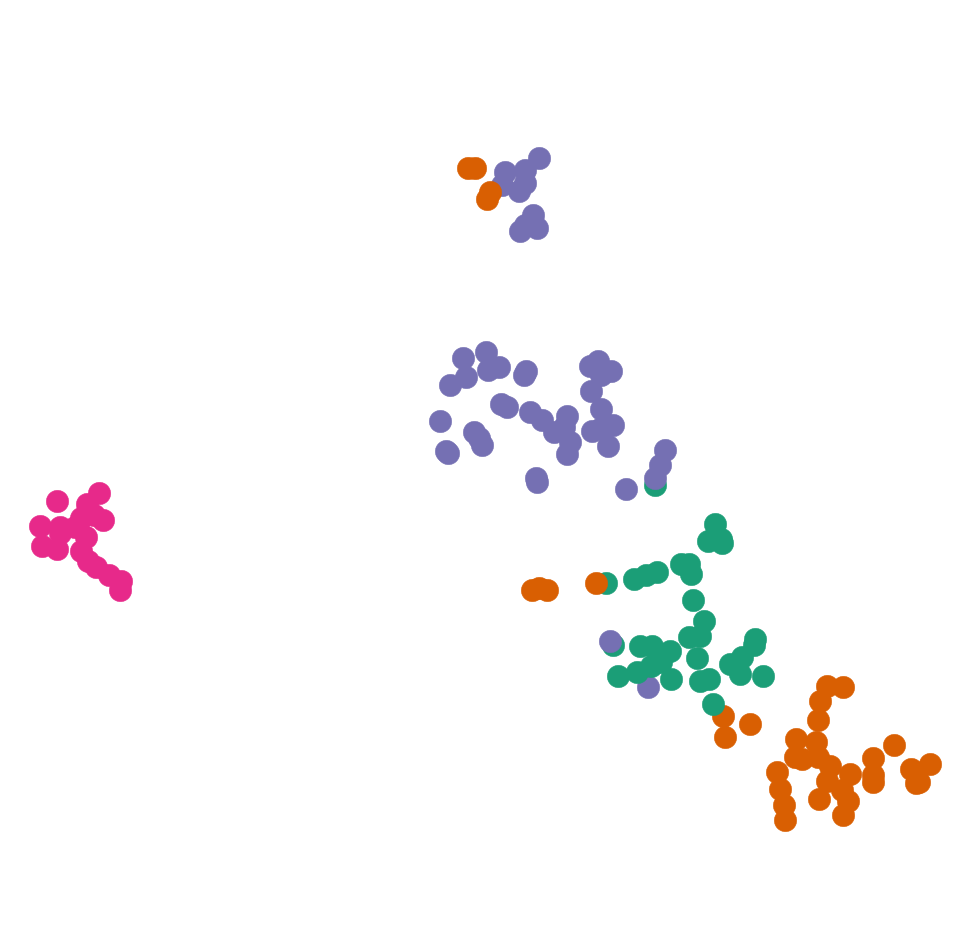

In [119]:
cells = cl_c_MEL_S
tsne = tsne_MEL_S.loc[cells.index]
cmap = cmap_MEL_S
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 500,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_FigS8_tSNE_MEL_Seurat.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

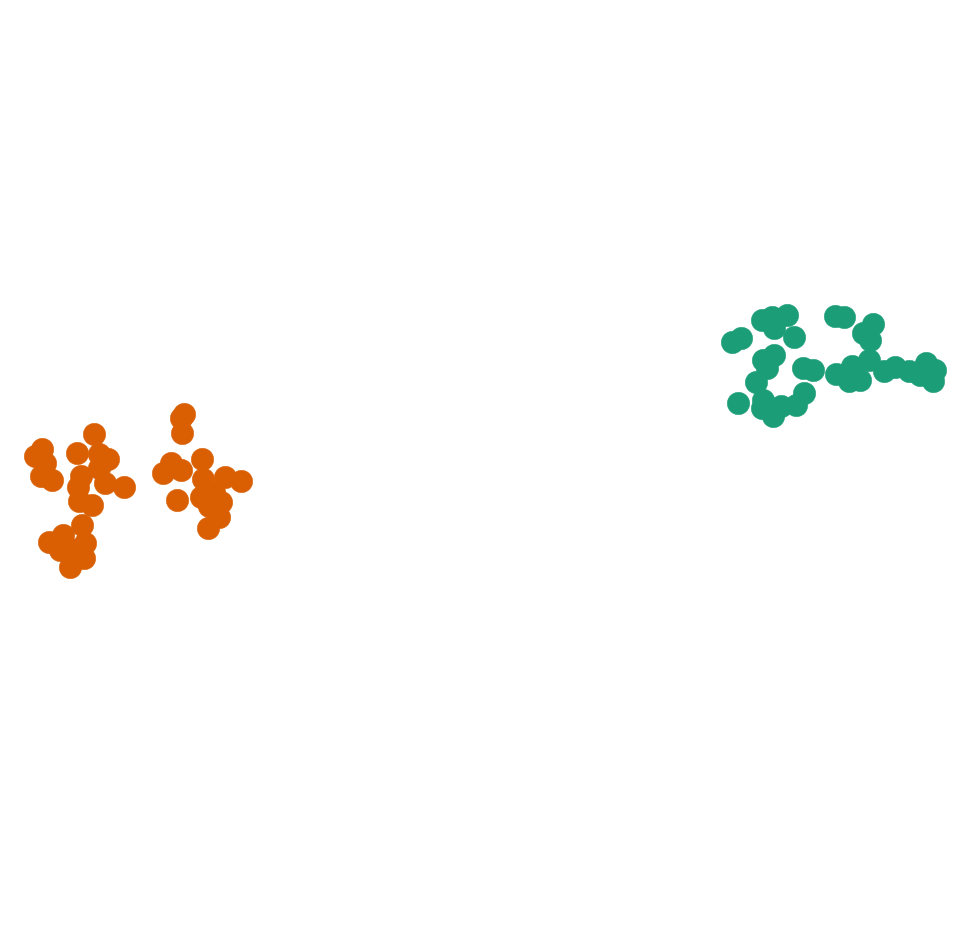

In [120]:
cells = cl_c_MISC_S
tsne = tsne_MISC_S.loc[cells.index]
cmap = cmap_MISC_S
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 500,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_FigS8_tSNE_MISC_Seurat.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Cell-cell-distance

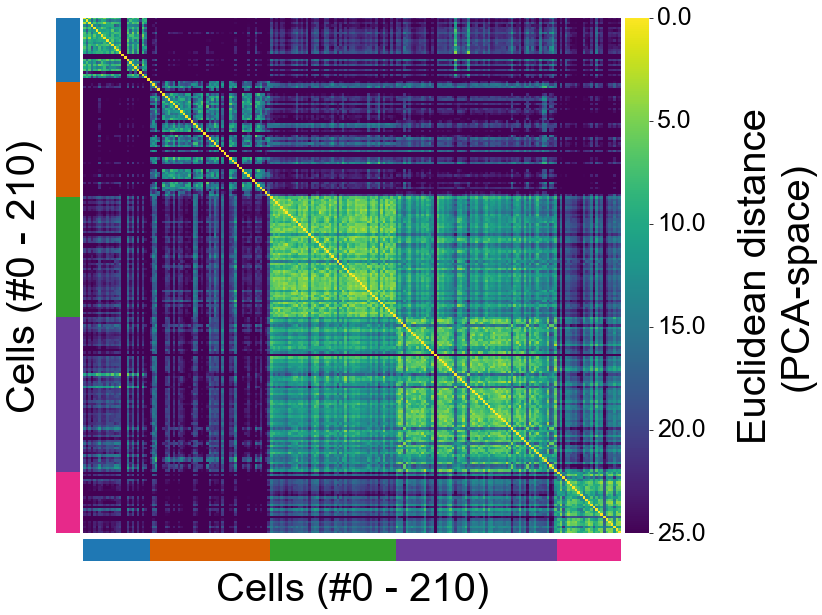

In [121]:
groups = cl_c_IMM_S
dist = dist_c_IMM
dist = dist.loc[groups.index, groups.index]
vmin = 0
vmax = 25
cmap = plt.cm.viridis_r
cmap_groups = cmap_IMM_S

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (10.625, 10))
gs = plt.GridSpec(nrows = 2, ncols = 3, wspace=0.02, hspace=0.02, width_ratios=[0.5 , 11.25, 0.5], height_ratios=[11.25, 0.5])

#plot heatmap

axHM = plt.subplot(gs[0, 1])

axHM.matshow(dist, cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax, interpolation = None)
    
axHM.set_xlabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)
axHM.set_ylabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)

axHM.xaxis.set_label_coords(0.5, -0.075)
axHM.yaxis.set_label_coords(-0.075, 0.5)
    
axHM.set_yticks([])

clean_axis(axHM)

#plot left sample groups

axSG1 = plt.subplot(gs[0, 0])

axSG1.set_ylim(len(groups), 0)

for pos, gr in enumerate(groups):
    axSG1.axhspan(pos, pos+1, color=cmap_groups[gr])
    
remove_ticks(axSG1)
clean_axis(axSG1)

#plot bottom sample groups

axSG2 = plt.subplot(gs[1, 1])

axSG2.set_xlim(0, len(groups))

for pos, gr in enumerate(groups):
    axSG2.axvspan(pos, pos+1, color=cmap_groups[gr])

remove_ticks(axSG2)
clean_axis(axSG2)

#plot label

axLabel = plt.subplot(gs[0,2])

axLabel.matshow(np.matrix(np.arange(vmin, vmax, 0.1)).T,
                cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks(np.linspace(axLabel.get_ylim()[0], axLabel.get_ylim()[1], 6))
axLabel.set_yticklabels(np.linspace(vmax, vmin, 6), family = 'Arial', fontsize = 25, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=5)

axLabel.set_ylabel('Euclidean distance\n(PCA-space)', family = 'Arial', fontsize = 40)
axLabel.yaxis.set_label_coords(8, 0.5)

figname = 'v1.5_FigS8_cell_cell_distance_IMM_Seurat.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

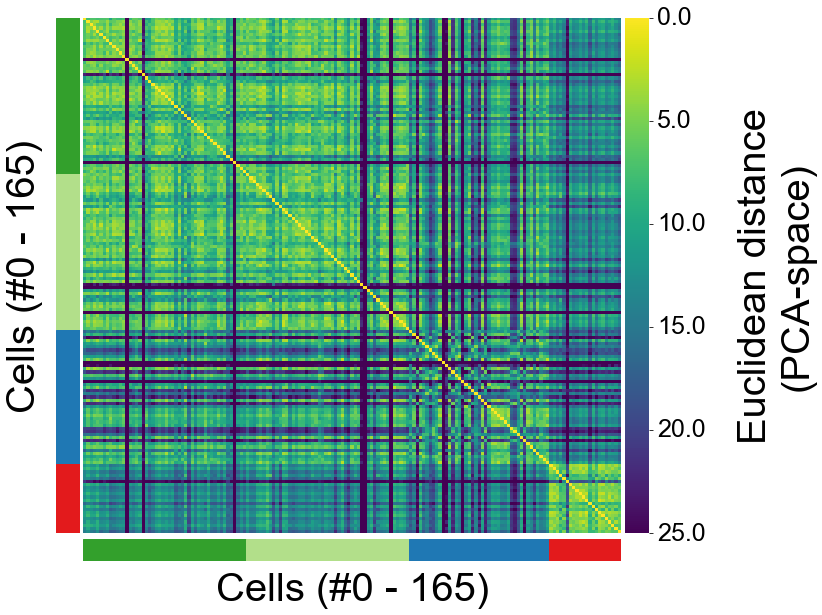

In [122]:
groups = cl_c_VASC_S
dist = dist_c_VASC
dist = dist.loc[groups.index, groups.index]
vmin = 0
vmax = 25
cmap = plt.cm.viridis_r
cmap_groups = cmap_VASC_S

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (10.625, 10))
gs = plt.GridSpec(nrows = 2, ncols = 3, wspace=0.02, hspace=0.02, width_ratios=[0.5 , 11.25, 0.5], height_ratios=[11.25, 0.5])

#plot heatmap

axHM = plt.subplot(gs[0, 1])

axHM.matshow(dist, cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax, interpolation = None)
    
axHM.set_xlabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)
axHM.set_ylabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)

axHM.xaxis.set_label_coords(0.5, -0.075)
axHM.yaxis.set_label_coords(-0.075, 0.5)
    
axHM.set_yticks([])

clean_axis(axHM)

#plot left sample groups

axSG1 = plt.subplot(gs[0, 0])

axSG1.set_ylim(len(groups), 0)

for pos, gr in enumerate(groups):
    axSG1.axhspan(pos, pos+1, color=cmap_groups[gr])
    
remove_ticks(axSG1)
clean_axis(axSG1)

#plot bottom sample groups

axSG2 = plt.subplot(gs[1, 1])

axSG2.set_xlim(0, len(groups))

for pos, gr in enumerate(groups):
    axSG2.axvspan(pos, pos+1, color=cmap_groups[gr])

remove_ticks(axSG2)
clean_axis(axSG2)

#plot label

axLabel = plt.subplot(gs[0,2])

axLabel.matshow(np.matrix(np.arange(vmin, vmax, 0.1)).T,
                cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks(np.linspace(axLabel.get_ylim()[0], axLabel.get_ylim()[1], 6))
axLabel.set_yticklabels(np.linspace(vmax, vmin, 6), family = 'Arial', fontsize = 25, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=5)

axLabel.set_ylabel('Euclidean distance\n(PCA-space)', family = 'Arial', fontsize = 40)
axLabel.yaxis.set_label_coords(8, 0.5)

figname = 'v1.5_FigS8_cell_cell_distance_VASC_Seurat.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

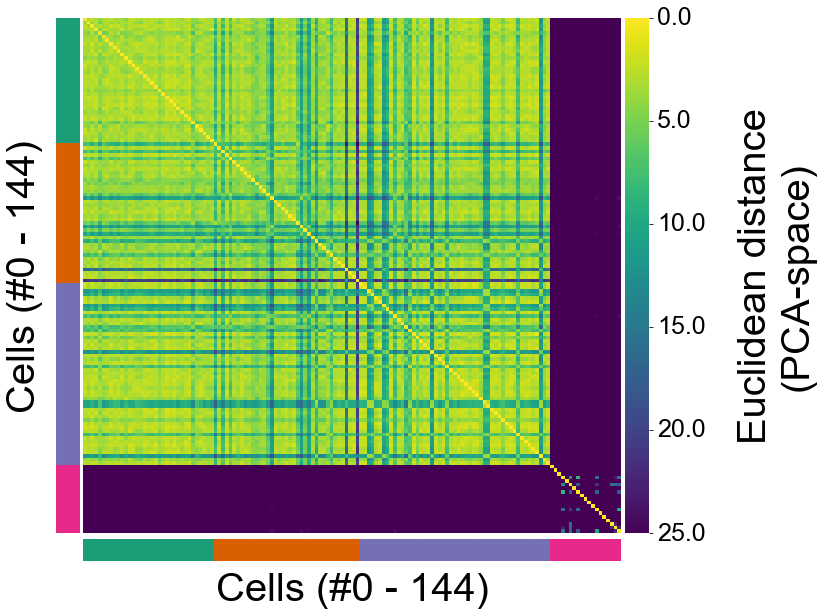

In [123]:
groups = cl_c_MEL_S
dist = dist_c_MEL
dist = dist.loc[groups.index, groups.index]
vmin = 0
vmax = 25
cmap = plt.cm.viridis_r
cmap_groups = cmap_MEL_S

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (10.625, 10))
gs = plt.GridSpec(nrows = 2, ncols = 3, wspace=0.02, hspace=0.02, width_ratios=[0.5 , 11.25, 0.5], height_ratios=[11.25, 0.5])

#plot heatmap

axHM = plt.subplot(gs[0, 1])

axHM.matshow(dist, cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax, interpolation = None)
    
axHM.set_xlabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)
axHM.set_ylabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)

axHM.xaxis.set_label_coords(0.5, -0.075)
axHM.yaxis.set_label_coords(-0.075, 0.5)
    
axHM.set_yticks([])

clean_axis(axHM)

#plot left sample groups

axSG1 = plt.subplot(gs[0, 0])

axSG1.set_ylim(len(groups), 0)

for pos, gr in enumerate(groups):
    axSG1.axhspan(pos, pos+1, color=cmap_groups[gr])
    
remove_ticks(axSG1)
clean_axis(axSG1)

#plot bottom sample groups

axSG2 = plt.subplot(gs[1, 1])

axSG2.set_xlim(0, len(groups))

for pos, gr in enumerate(groups):
    axSG2.axvspan(pos, pos+1, color=cmap_groups[gr])

remove_ticks(axSG2)
clean_axis(axSG2)

#plot label

axLabel = plt.subplot(gs[0,2])

axLabel.matshow(np.matrix(np.arange(vmin, vmax, 0.1)).T,
                cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks(np.linspace(axLabel.get_ylim()[0], axLabel.get_ylim()[1], 6))
axLabel.set_yticklabels(np.linspace(vmax, vmin, 6), family = 'Arial', fontsize = 25, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=5)

axLabel.set_ylabel('Euclidean distance\n(PCA-space)', family = 'Arial', fontsize = 40)
axLabel.yaxis.set_label_coords(8, 0.5)

figname = 'v1.5_FigS8_cell_cell_distance_MEL_Seurat.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

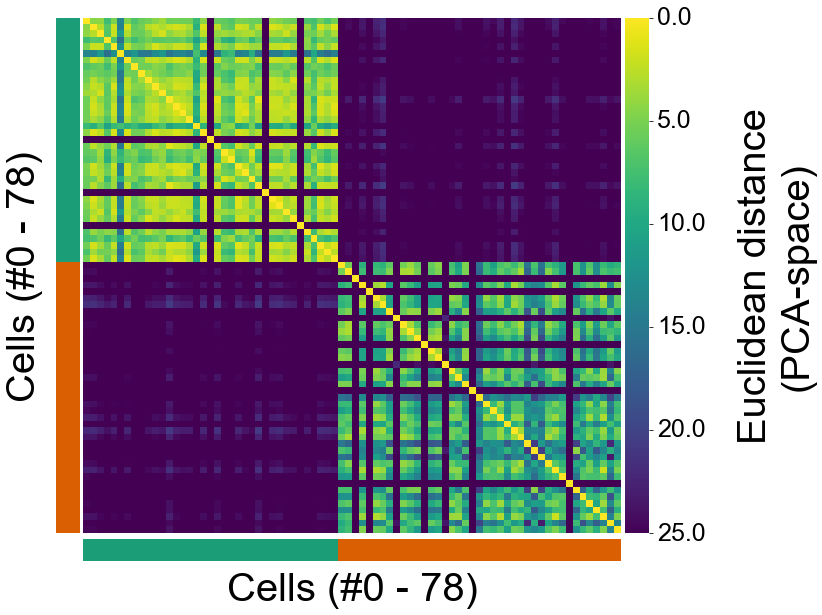

In [124]:
groups = cl_c_MISC_S
dist = dist_c_MISC
dist = dist.loc[groups.index, groups.index]
vmin = 0
vmax = 25
cmap = plt.cm.viridis_r
cmap_groups = cmap_MISC_S

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (10.625, 10))
gs = plt.GridSpec(nrows = 2, ncols = 3, wspace=0.02, hspace=0.02, width_ratios=[0.5 , 11.25, 0.5], height_ratios=[11.25, 0.5])

#plot heatmap

axHM = plt.subplot(gs[0, 1])

axHM.matshow(dist, cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax, interpolation = None)
    
axHM.set_xlabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)
axHM.set_ylabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)

axHM.xaxis.set_label_coords(0.5, -0.075)
axHM.yaxis.set_label_coords(-0.075, 0.5)
    
axHM.set_yticks([])

clean_axis(axHM)

#plot left sample groups

axSG1 = plt.subplot(gs[0, 0])

axSG1.set_ylim(len(groups), 0)

for pos, gr in enumerate(groups):
    axSG1.axhspan(pos, pos+1, color=cmap_groups[gr])
    
remove_ticks(axSG1)
clean_axis(axSG1)

#plot bottom sample groups

axSG2 = plt.subplot(gs[1, 1])

axSG2.set_xlim(0, len(groups))

for pos, gr in enumerate(groups):
    axSG2.axvspan(pos, pos+1, color=cmap_groups[gr])

remove_ticks(axSG2)
clean_axis(axSG2)

#plot label

axLabel = plt.subplot(gs[0,2])

axLabel.matshow(np.matrix(np.arange(vmin, vmax, 0.1)).T,
                cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks(np.linspace(axLabel.get_ylim()[0], axLabel.get_ylim()[1], 6))
axLabel.set_yticklabels(np.linspace(vmax, vmin, 6), family = 'Arial', fontsize = 25, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=5)

axLabel.set_ylabel('Euclidean distance\n(PCA-space)', family = 'Arial', fontsize = 40)
axLabel.yaxis.set_label_coords(8, 0.5)

figname = 'v1.5_FigS8_cell_cell_distance_MISC_Seurat.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Comparison

In [57]:
def heatmap_diag(hm):
    
    import operator
    
    #get dict and sort
    
    d = {}
    
    for r in hm.index:
        for c in hm.columns:
            d[(r,c)] = hm.loc[r,c]
            
    r_sort, c_sort = [], []
            
    d = sorted(d.items(), key=operator.itemgetter(1), reverse = True)
    
    for i in d:
        if i[0][0] not in r_sort and i[0][1] not in c_sort:
            r_sort += [i[0][0]]
            c_sort += [i[0][1]]
    
    r_sort += [r for r in hm.index if r not in r_sort]
    c_sort += [c for c in hm.columns if c not in c_sort]
    
    return hm.loc[r_sort, c_sort]

In [58]:
def seurat_vs_AP(cl_ix, cl_col, return_counts = False):
    
    #define output
    
    output_perc = pd.DataFrame(index = return_unique(cl_ix), columns = return_unique(cl_col))
    output_count = pd.DataFrame(index = return_unique(cl_ix), columns = return_unique(cl_col))
    
    for col in return_unique(cl_col):
        ix_col = set(cl_col[cl_col==col].index)
        
        for row in return_unique(cl_ix):
            ix_row = set(cl_ix[cl_ix==row].index)
            
            output_perc.loc[row, col] = float(len(ix_row&ix_col)) / float(len(ix_row))
            output_count.loc[row, col] = float(len(ix_row&ix_col))
    
    if return_counts == True:
        return heatmap_diag(output_perc), output_count
    else:    
        return heatmap_diag(output)

In [59]:
seurat_vs_AP_IMM_perc, seurat_vs_AP_IMM_count = seurat_vs_AP(cl_c_IMM[c_sel_IMM], cl_c_IMM_S[c_sel_IMM], True)

In [60]:
overlap_IMM_ax0 = seurat_vs_AP_IMM_count.max(axis=0).sum() / seurat_vs_AP_IMM_count.sum().sum()
overlap_IMM_ax1 = seurat_vs_AP_IMM_count.max(axis=1).sum() / seurat_vs_AP_IMM_count.sum().sum()

In [61]:
print(overlap_IMM_ax0, overlap_IMM_ax1)

0.9285714285714286 0.9571428571428572


In [62]:
from sklearn.metrics import adjusted_rand_score as rand

In [63]:
rand_IMM = rand(cl_c_IMM, cl_c_IMM_S)

In [64]:
rand_IMM

0.8176474564041226

In [130]:
ix_sel = ['IMM - 4','IMM - 0','IMM - 2','IMM - 5','IMM - 3','IMM - 1']

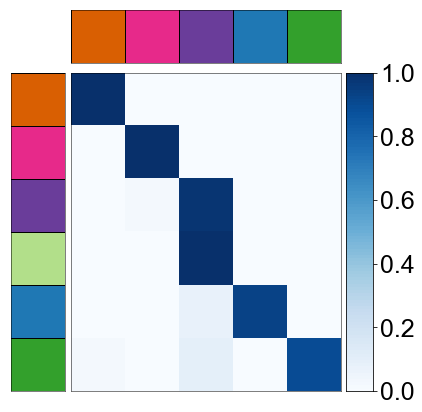

In [131]:
data = seurat_vs_AP_IMM_perc.loc[ix_sel]

cmap_ix = cmap_2nd
cmap_col = cmap_IMM_S

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (len(data.columns) + 1.5, len(data.index) + 1))
gs = plt.GridSpec(nrows = 2, ncols = 3, 
                  wspace=0.05, width_ratios=[1,1*len(data.columns),0.5], 
                  hspace=0.05, height_ratios=[1,1*len(data.index)])

#plot population colors

ax = plt.subplot(gs[1,0])

ax.set_ylim(len(data.index), 0)

for pos, gr in enumerate(data.index):
    ax.axhspan(pos, pos + 1, color = cmap_ix[gr])
    ax.axhline(pos, lw = 1, color = 'k')
    
remove_ticks(ax)

ax = plt.subplot(gs[0,1])

ax.set_xlim(0, len(data.columns))

for pos, gr in enumerate(data.columns):
    ax.axvspan(pos, pos + 1, color = cmap_col[gr])
    ax.axvline(pos, lw = 1, color = 'k')
    
remove_ticks(ax)

#plot data

ax = plt.subplot(gs[1,1])

ax.imshow(data.astype(float),
          cmap = plt.cm.Blues,
          aspect = 'auto',
          interpolation = 'nearest',
          vmin = 0, vmax = 1)

remove_ticks(ax)

#plot legend

ax = plt.subplot(gs[1,2])

ax.set_ylim(0,1)
ax.set_xticks([])

ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], family = 'Arial', fontsize = 25)
ax.yaxis.set_ticks_position('right')

for pos in np.arange(0,1,0.01):
    ax.axhspan(pos, pos + 0.01, color = plt.cm.Blues(pos))
    
figname = 'v1.5_FigS8_seurat_AP_comp_IMM.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

In [65]:
seurat_vs_AP_VASC_perc, seurat_vs_AP_VASC_count = seurat_vs_AP(cl_c_VASC[c_sel_VASC], cl_c_VASC_S[c_sel_VASC], True)

In [66]:
overlap_VASC_ax0 = seurat_vs_AP_VASC_count.max(axis=0).sum() / seurat_vs_AP_VASC_count.sum().sum()
overlap_VASC_ax1 = seurat_vs_AP_VASC_count.max(axis=1).sum() / seurat_vs_AP_VASC_count.sum().sum()

In [67]:
print(overlap_VASC_ax0, overlap_VASC_ax1)

0.6484848484848484 0.6303030303030303


In [68]:
rand_VASC = rand(cl_c_VASC, cl_c_VASC_S)

In [69]:
rand_VASC

0.5679391147251275

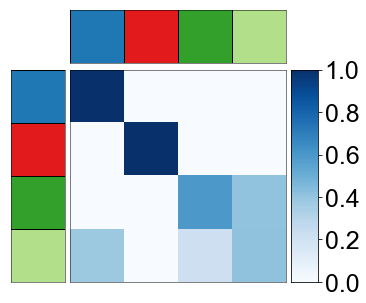

In [135]:
data = seurat_vs_AP_VASC_perc

cmap_ix = cmap_2nd
cmap_col = cmap_VASC_S

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (len(data.columns) + 1.5, len(data.index) + 1))
gs = plt.GridSpec(nrows = 2, ncols = 3, 
                  wspace=0.05, width_ratios=[1,1*len(data.columns),0.5], 
                  hspace=0.05, height_ratios=[1,1*len(data.index)])

#plot population colors

ax = plt.subplot(gs[1,0])

ax.set_ylim(len(data.index), 0)

for pos, gr in enumerate(data.index):
    ax.axhspan(pos, pos + 1, color = cmap_ix[gr])
    ax.axhline(pos, lw = 1, color = 'k')
    
remove_ticks(ax)

ax = plt.subplot(gs[0,1])

ax.set_xlim(0, len(data.columns))

for pos, gr in enumerate(data.columns):
    ax.axvspan(pos, pos + 1, color = cmap_col[gr])
    ax.axvline(pos, lw = 1, color = 'k')
    
remove_ticks(ax)

#plot data

ax = plt.subplot(gs[1,1])

ax.imshow(data.astype(float),
          cmap = plt.cm.Blues,
          aspect = 'auto',
          interpolation = 'nearest',
          vmin = 0, vmax = 1)

remove_ticks(ax)

#plot legend

ax = plt.subplot(gs[1,2])

ax.set_ylim(0,1)
ax.set_xticks([])

ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], family = 'Arial', fontsize = 25)
ax.yaxis.set_ticks_position('right')

for pos in np.arange(0,1,0.01):
    ax.axhspan(pos, pos + 0.01, color = plt.cm.Blues(pos))
    
figname = 'v1.5_FigS8_seurat_AP_comp_VASC.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

In [70]:
seurat_vs_AP_MEL_perc, seurat_vs_AP_MEL_count = seurat_vs_AP(cl_c_MEL[c_sel_MEL], cl_c_MEL_S[c_sel_MEL], True)

In [71]:
overlap_MEL_ax0 = seurat_vs_AP_MEL_count.max(axis=0).sum() / seurat_vs_AP_MEL_count.sum().sum()
overlap_MEL_ax1 = seurat_vs_AP_MEL_count.max(axis=1).sum() / seurat_vs_AP_MEL_count.sum().sum()

In [72]:
print(overlap_MEL_ax0, overlap_MEL_ax1)

0.8958333333333334 0.4861111111111111


In [73]:
rand_MEL = rand(cl_c_MEL, cl_c_MEL_S)

In [74]:
rand_MEL

0.27808812685187745

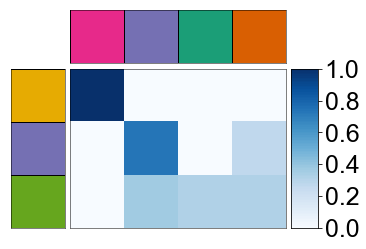

In [139]:
data = seurat_vs_AP_MEL_perc

cmap_ix = cmap_2nd
cmap_col = cmap_MEL_S

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (len(data.columns) + 1.5, len(data.index) + 1))
gs = plt.GridSpec(nrows = 2, ncols = 3, 
                  wspace=0.05, width_ratios=[1,1*len(data.columns),0.5], 
                  hspace=0.05, height_ratios=[1,1*len(data.index)])

#plot population colors

ax = plt.subplot(gs[1,0])

ax.set_ylim(len(data.index), 0)

for pos, gr in enumerate(data.index):
    ax.axhspan(pos, pos + 1, color = cmap_ix[gr])
    ax.axhline(pos, lw = 1, color = 'k')
    
remove_ticks(ax)

ax = plt.subplot(gs[0,1])

ax.set_xlim(0, len(data.columns))

for pos, gr in enumerate(data.columns):
    ax.axvspan(pos, pos + 1, color = cmap_col[gr])
    ax.axvline(pos, lw = 1, color = 'k')
    
remove_ticks(ax)

#plot data

ax = plt.subplot(gs[1,1])

ax.imshow(data.astype(float),
          cmap = plt.cm.Blues,
          aspect = 'auto',
          interpolation = 'nearest',
          vmin = 0, vmax = 1)

remove_ticks(ax)

#plot legend

ax = plt.subplot(gs[1,2])

ax.set_ylim(0,1)
ax.set_xticks([])

ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], family = 'Arial', fontsize = 25)
ax.yaxis.set_ticks_position('right')

for pos in np.arange(0,1,0.01):
    ax.axhspan(pos, pos + 0.01, color = plt.cm.Blues(pos))
    
figname = 'v1.5_FigS8_seurat_AP_comp_MEL.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

In [140]:
seurat_vs_AP_MISC_perc, seurat_vs_AP_MISC_count = seurat_vs_AP(cl_c_MISC[c_sel_MISC], cl_c_MISC_S[c_sel_MISC], True)

In [141]:
overlap_MISC_ax0 = seurat_vs_AP_MISC_count.max(axis=0).sum() / seurat_vs_AP_MISC_count.sum().sum()
overlap_MISC_ax1 = seurat_vs_AP_MISC_count.max(axis=1).sum() / seurat_vs_AP_MISC_count.sum().sum()

In [142]:
print(overlap_MISC_ax0, overlap_MISC_ax1)

1.0 1.0


In [75]:
rand_MISC = rand(cl_c_MISC, cl_c_MISC_S)

In [76]:
rand_MISC

1.0

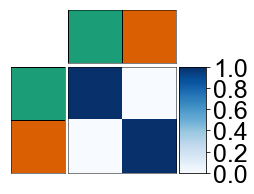

In [143]:
data = seurat_vs_AP_MISC_perc

cmap_ix = cmap_2nd
cmap_col = cmap_MISC_S

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (len(data.columns) + 1.5, len(data.index) + 1))
gs = plt.GridSpec(nrows = 2, ncols = 3, 
                  wspace=0.05, width_ratios=[1,1*len(data.columns),0.5], 
                  hspace=0.05, height_ratios=[1,1*len(data.index)])

#plot population colors

ax = plt.subplot(gs[1,0])

ax.set_ylim(len(data.index), 0)

for pos, gr in enumerate(data.index):
    ax.axhspan(pos, pos + 1, color = cmap_ix[gr])
    ax.axhline(pos, lw = 1, color = 'k')
    
remove_ticks(ax)

ax = plt.subplot(gs[0,1])

ax.set_xlim(0, len(data.columns))

for pos, gr in enumerate(data.columns):
    ax.axvspan(pos, pos + 1, color = cmap_col[gr])
    ax.axvline(pos, lw = 1, color = 'k')
    
remove_ticks(ax)

#plot data

ax = plt.subplot(gs[1,1])

ax.imshow(data.astype(float),
          cmap = plt.cm.Blues,
          aspect = 'auto',
          interpolation = 'nearest',
          vmin = 0, vmax = 1)

remove_ticks(ax)

#plot legend

ax = plt.subplot(gs[1,2])

ax.set_ylim(0,1)
ax.set_xticks([])

ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], family = 'Arial', fontsize = 25)
ax.yaxis.set_ticks_position('right')

for pos in np.arange(0,1,0.01):
    ax.axhspan(pos, pos + 0.01, color = plt.cm.Blues(pos))
    
figname = 'v1.5_FigS8_seurat_AP_comp_MISC.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)